# Predicting Car Prices 

In [1]:
import numpy as np
import pandas as pd

from PythonScripts import wrangle , explore, scale, evaluate

import warnings
warnings.filterwarnings('ignore')

## Executive Summary
- Project scope: The point of this regression model is to able to predict car prices.
- Datafound here https://www.kaggle.com/ananaymital/us-used-cars-dataset
- Using a 3rd degree polynomial, I was able to predict with an RMSE of about 5000

#### To-Do List
 - Create README on github that allows for project understanding
 - Find a dataset for used cars and there pricing 
 - create a function to put it into a pandas a dataframe
 - wrangle and explore, create a model that allows us to predict car price.
 - deploy this model into a phone app that allows you to  number 

## Wrangle
- Data Wrangling walkthough will explain what columns wer dropped and how nulls were imputed

In [2]:
#This database has 3 million observations
#we'll use 200,000 due to ram limitations
cars_df = wrangle.get_car_data(200000)
cars_df.shape

(200000, 66)

In [57]:
cars_df = wrangle.clean_car_data(cars_df)
cars_df.shape

<class 'pandas.core.series.Series'>


KeyError: "['bed_height' 'bed_length'] not found in axis"

In [58]:
cars_df.columns

Index(['vin', 'back_legroom', 'body_type', 'city', 'city_fuel_economy',
       'daysonmarket', 'dealer_zip', 'engine_displacement', 'engine_type',
       'exterior_color', 'fleet', 'frame_damaged', 'franchise_dealer',
       'front_legroom', 'fuel_tank_volume', 'fuel_type', 'has_accidents',
       'height', 'highway_fuel_economy', 'horsepower', 'interior_color',
       'is_new', 'latitude', 'length', 'listing_color', 'longitude',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count',
       'price', 'sp_id', 'transmission_display', 'trimId', 'trim_name',
       'wheel_system', 'wheelbase', 'width', 'year', 'age_of_car',
       'body_type_num', 'city_num', 'dealer_zip_num', 'engine_type_num',
       'exterior_color_num', 'fleet_num', 'fuel_type_num',
       'interior_color_num', 'listing_color_num', 'make_name_num',
       'model_name_num', 'transmission_display_num', 'trim_name_num',
       'wheel_system_num'],
      dtype='object')

### Encode / Split / Scale
Here I will encode all categorical objects into numbers for the regression model

In [4]:
encoded_cars = wrangle.encode_cars(cars_df)

In [5]:
train, validate, test = wrangle.split_for_model(encoded_cars)

train(49009, 55),validate(21004, 55),test(17504, 55)


In [6]:
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, scale_type='Robust', to_scale=['back_legroom','city_fuel_economy', 'daysonmarket', 'engine_displacement', 'front_legroom','fuel_tank_volume', 'height', 'highway_fuel_economy', 'horsepower', 'length', 'mileage','wheelbase', 'width'])

### Exploration

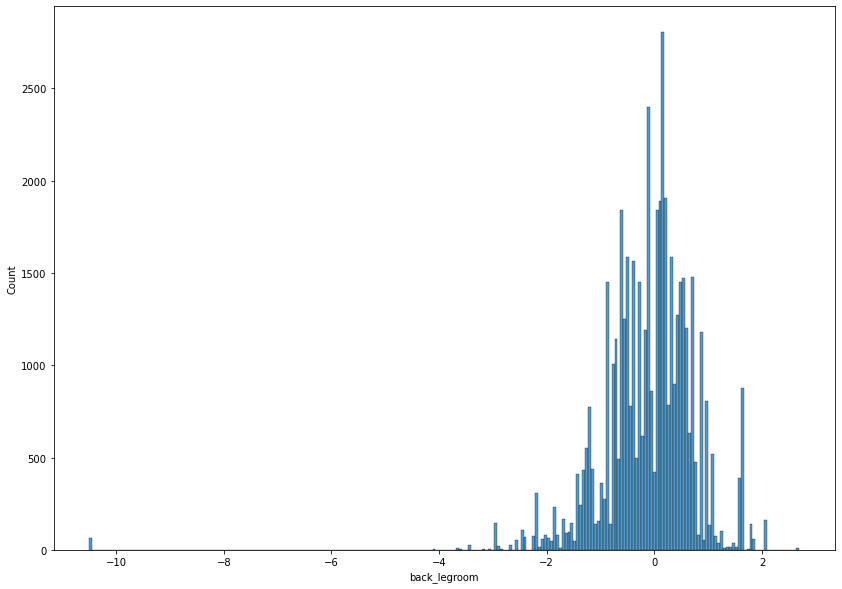

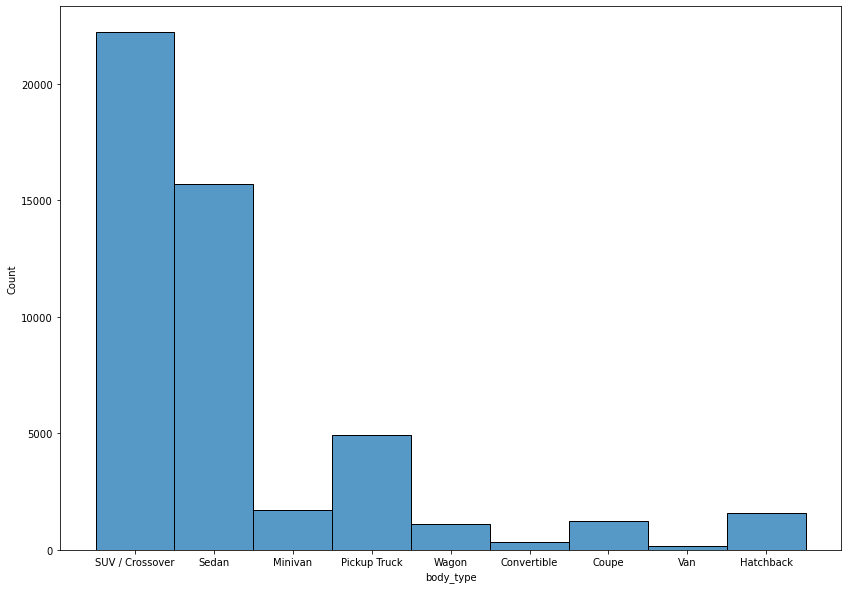

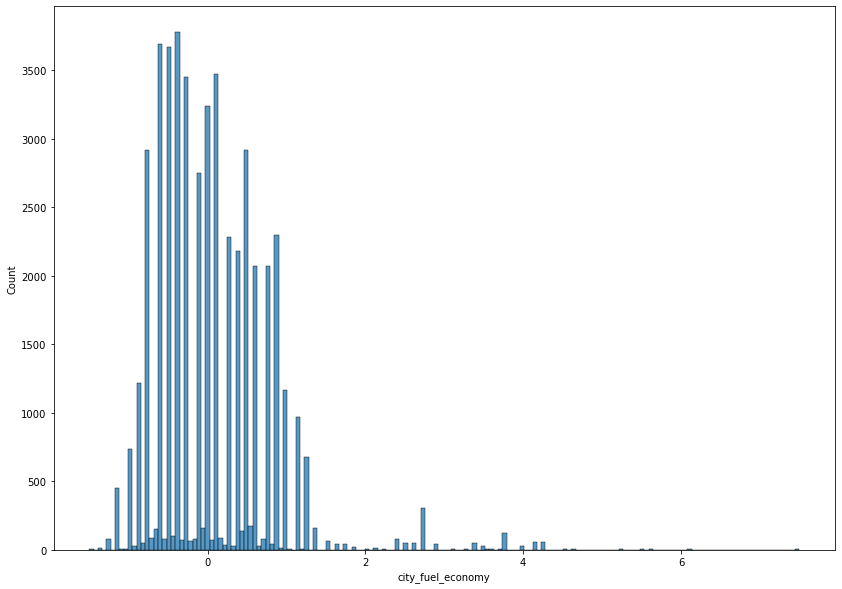

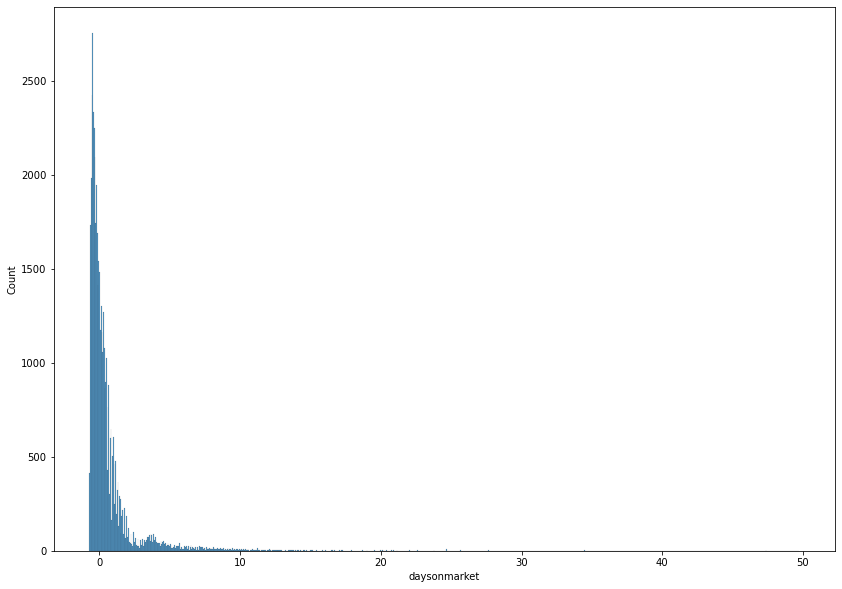

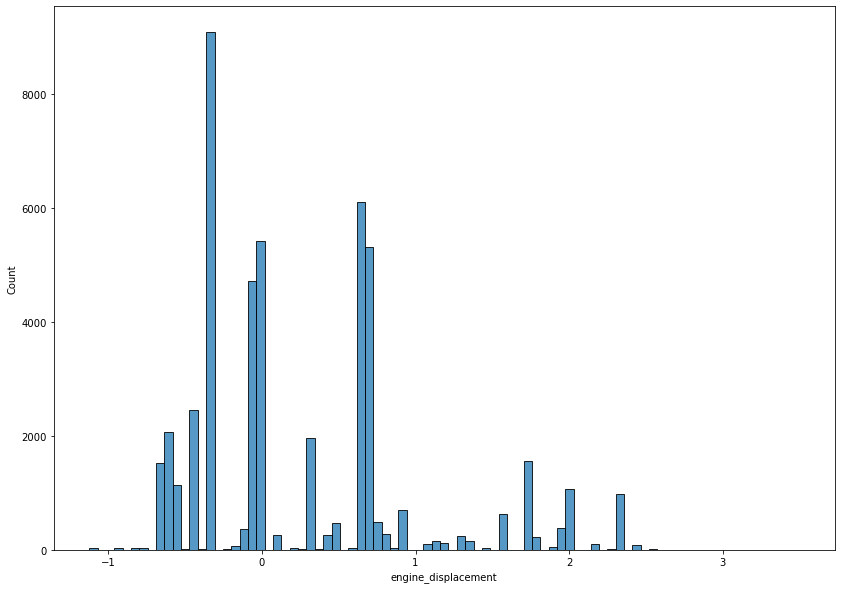

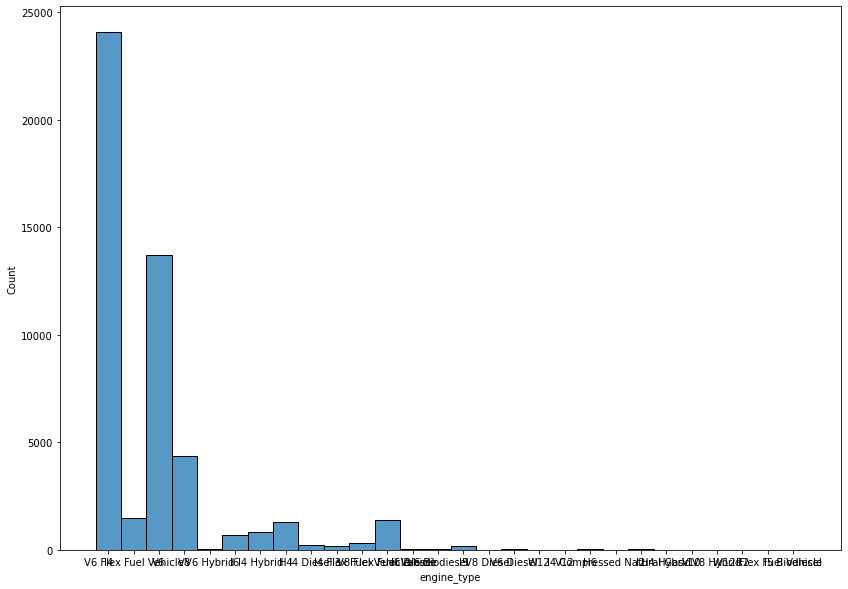

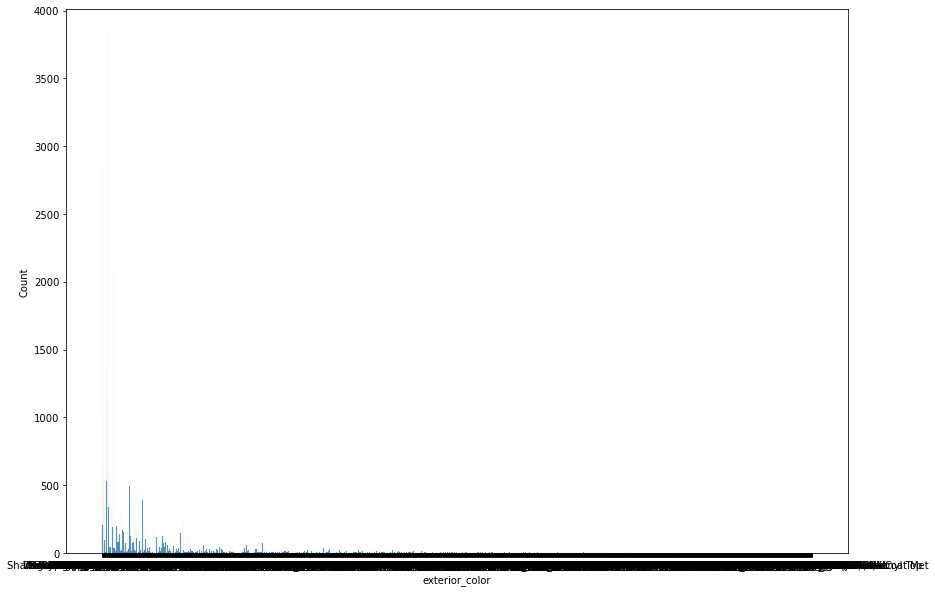

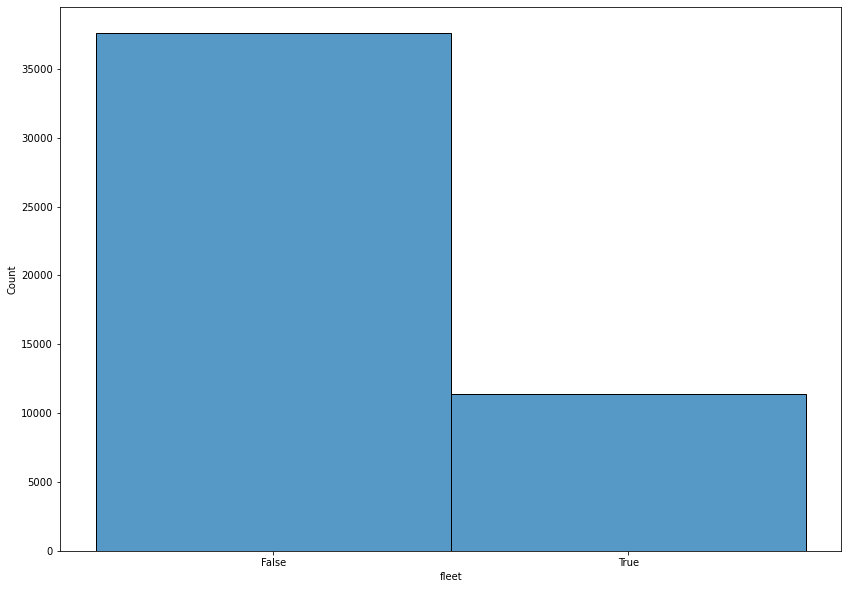

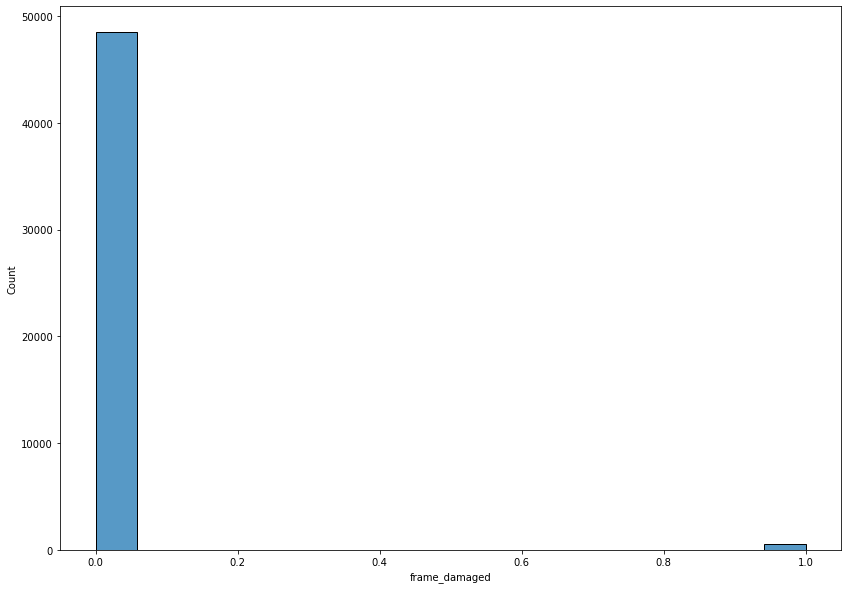

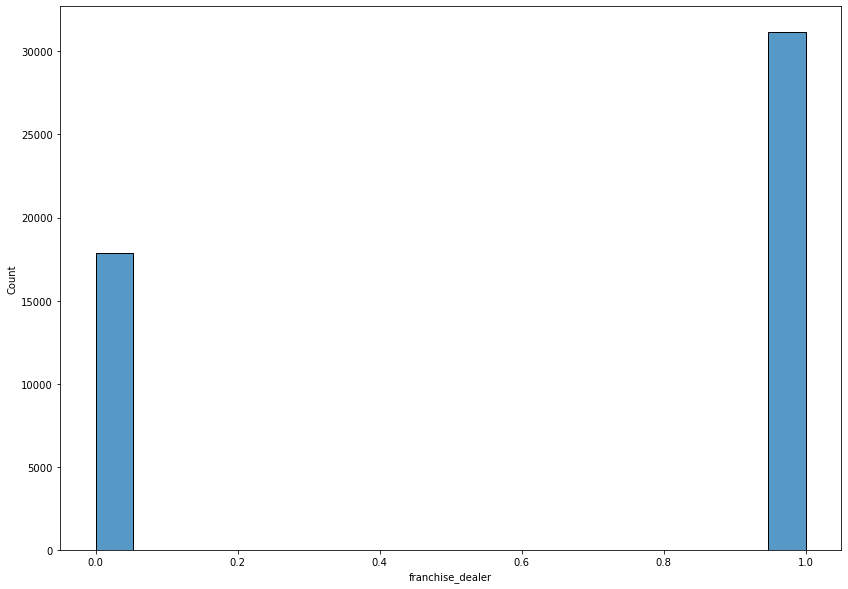

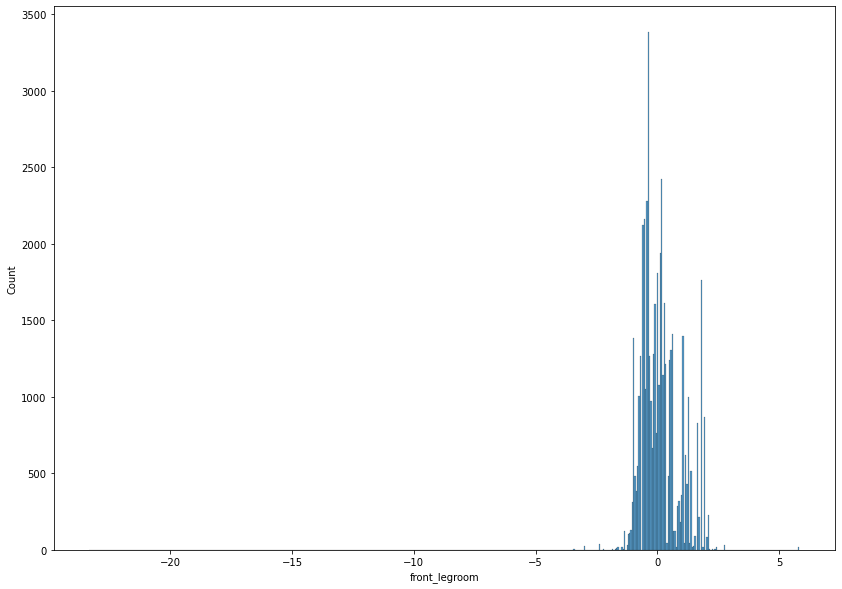

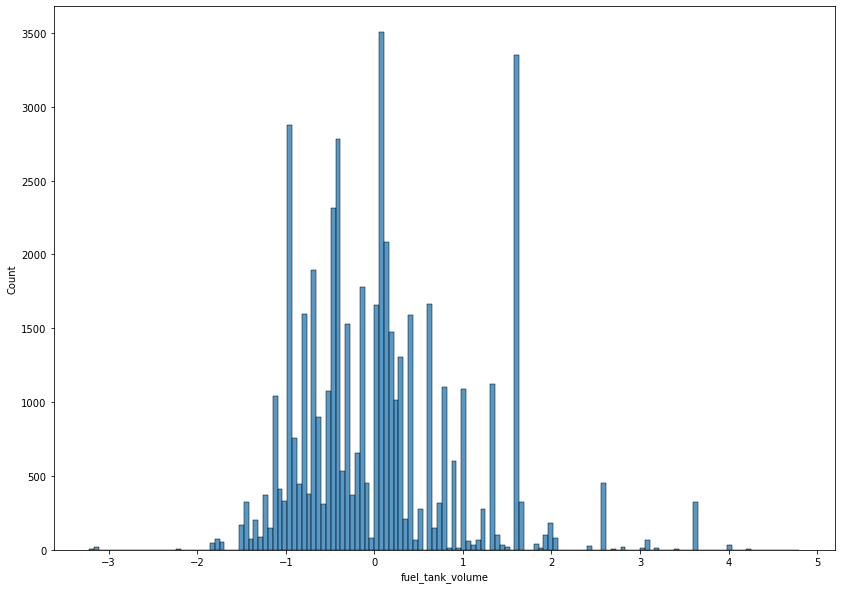

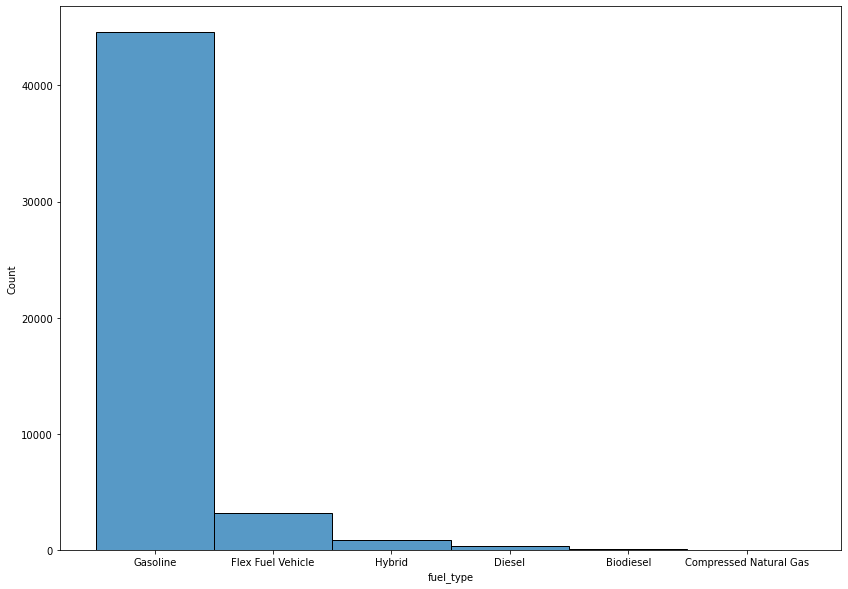

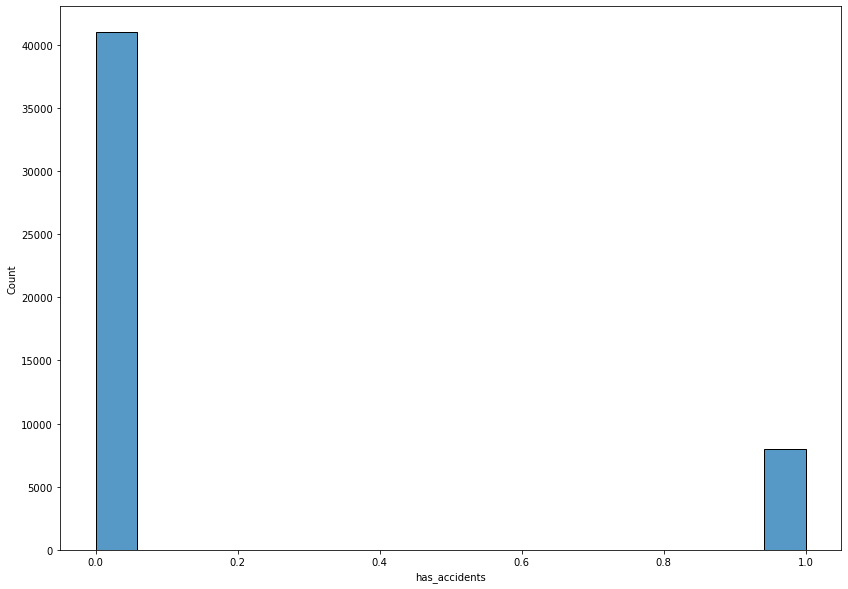

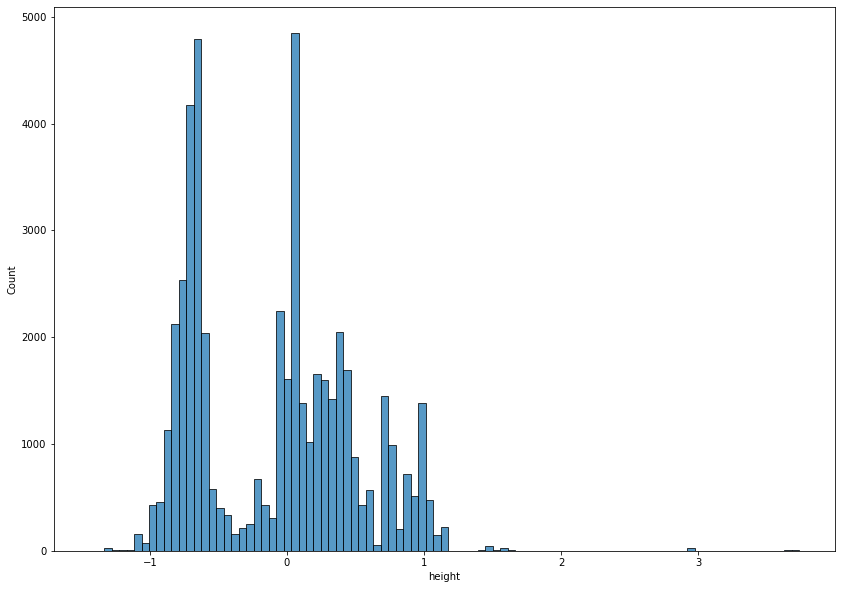

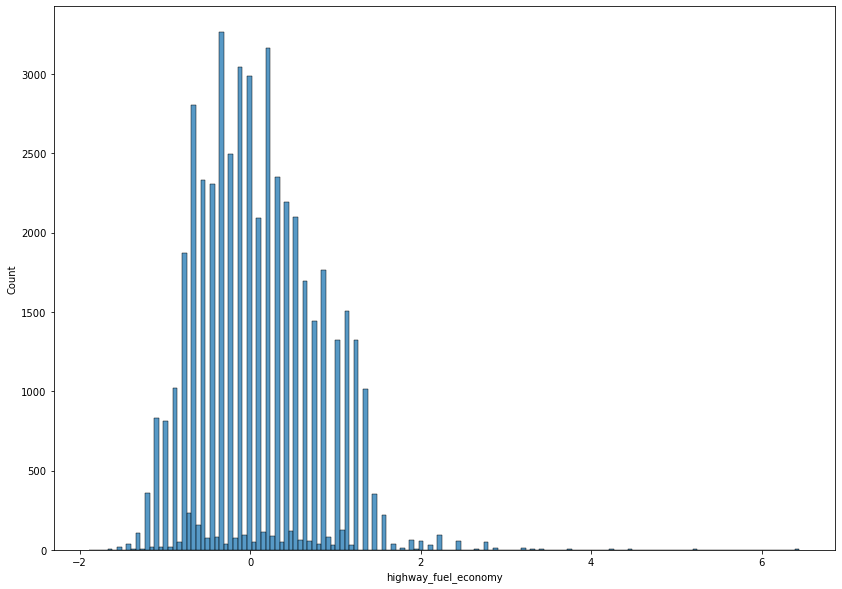

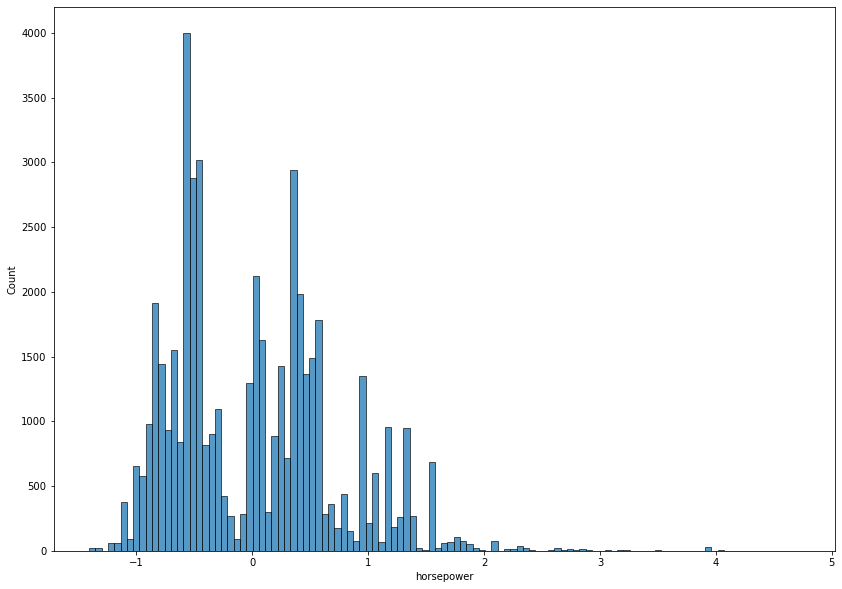

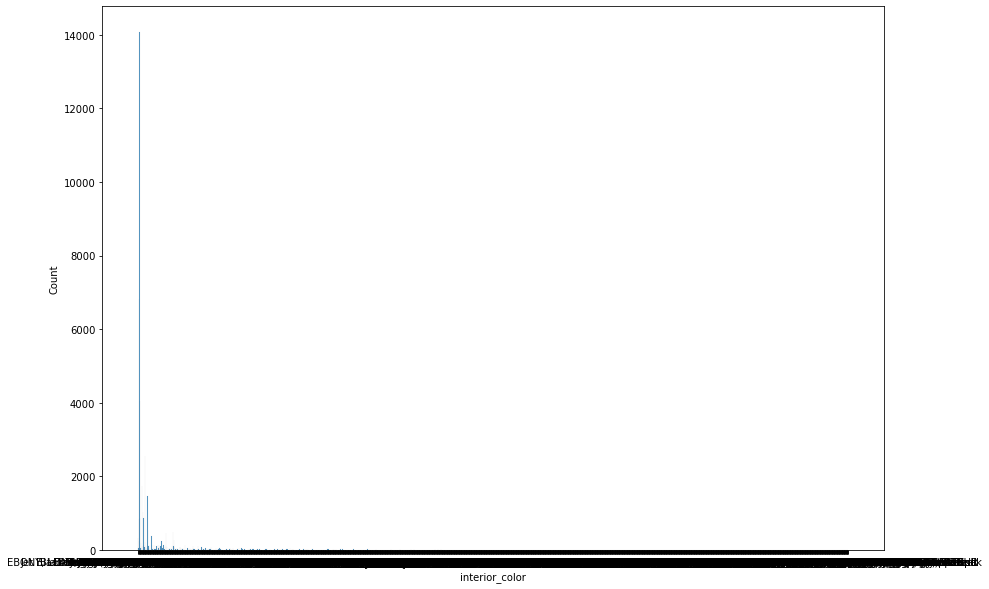

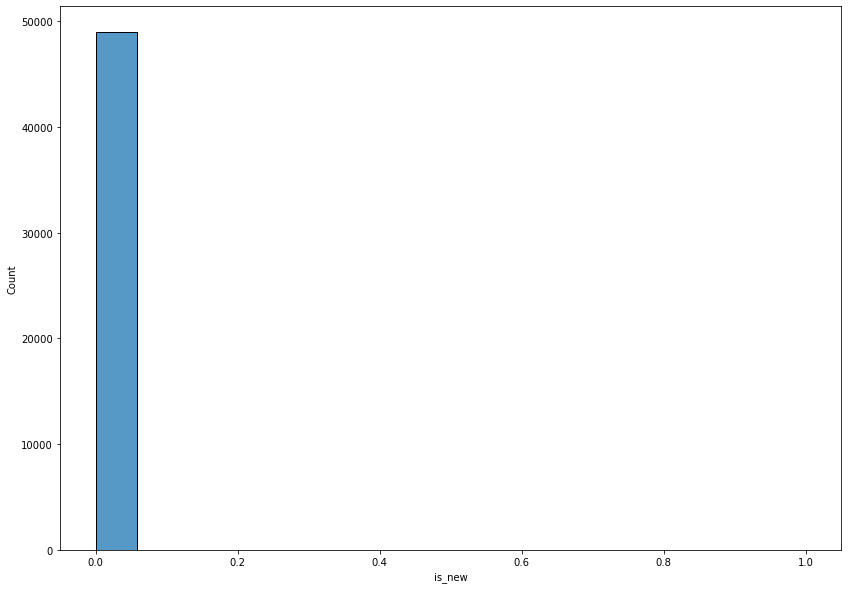

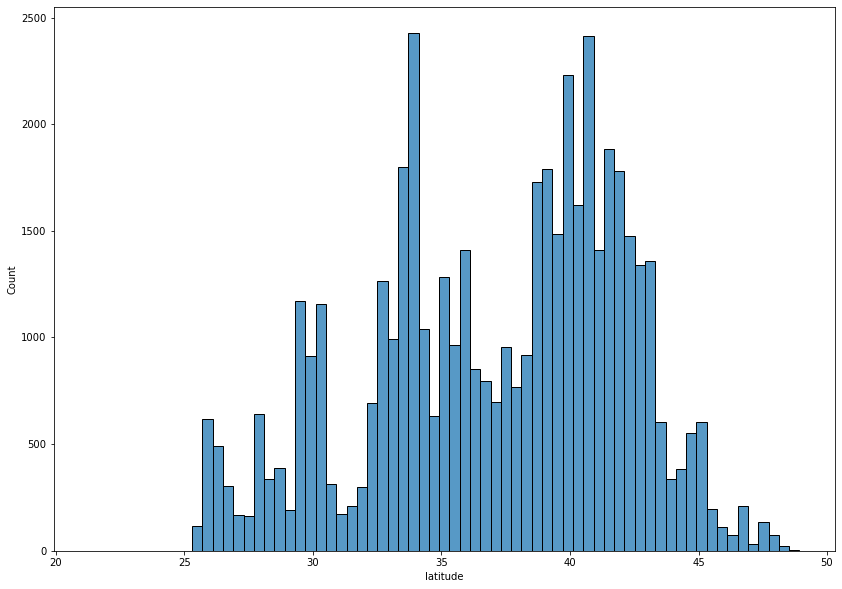

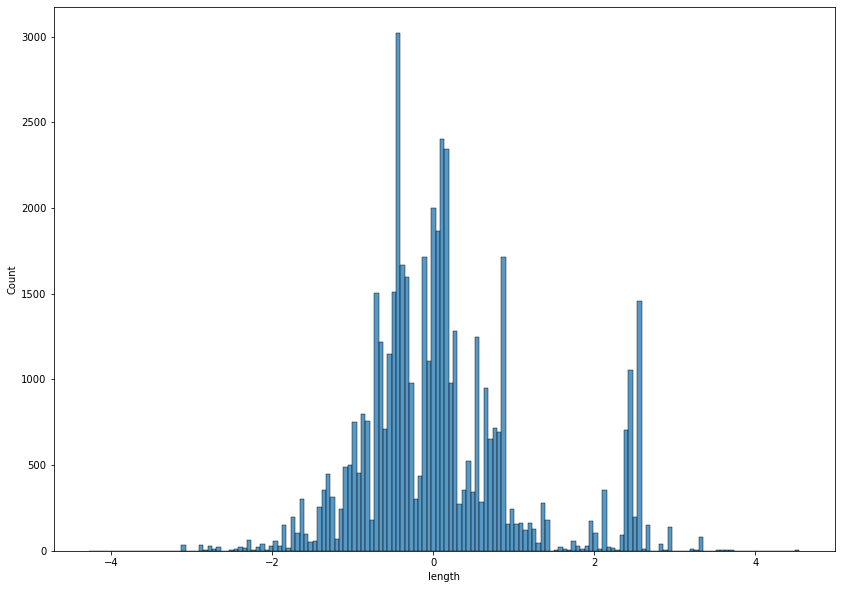

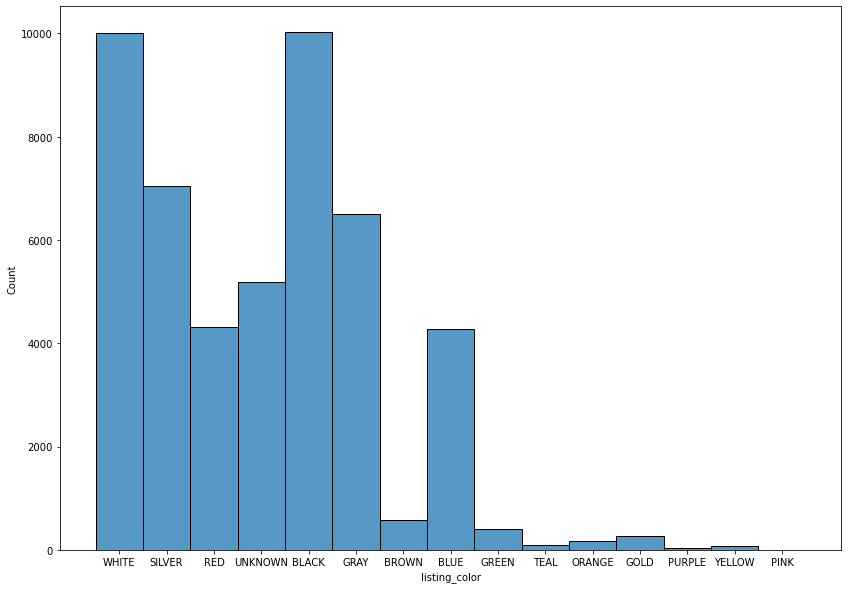

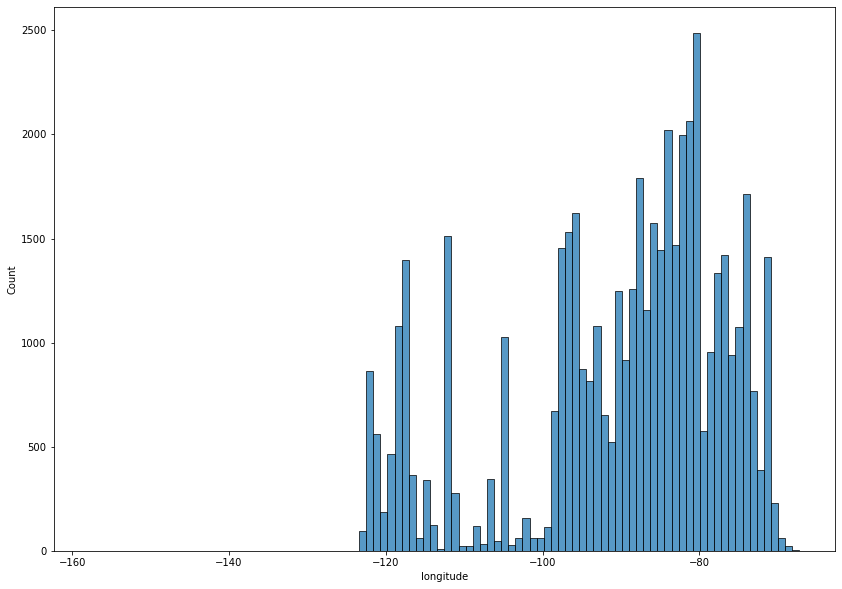

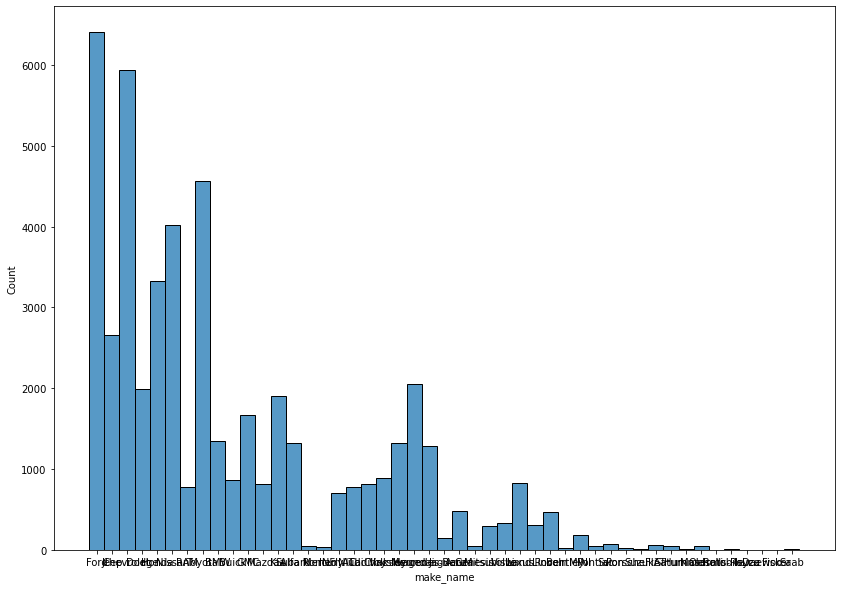

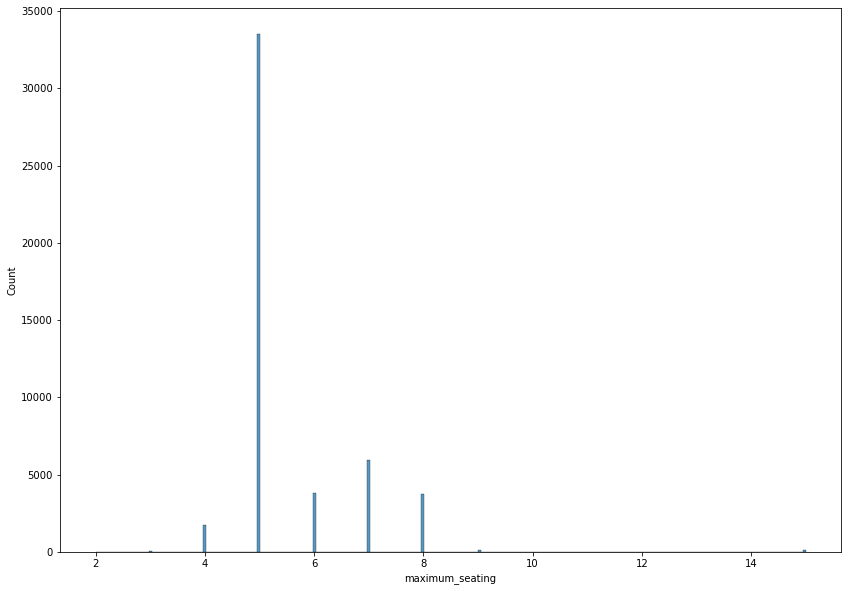

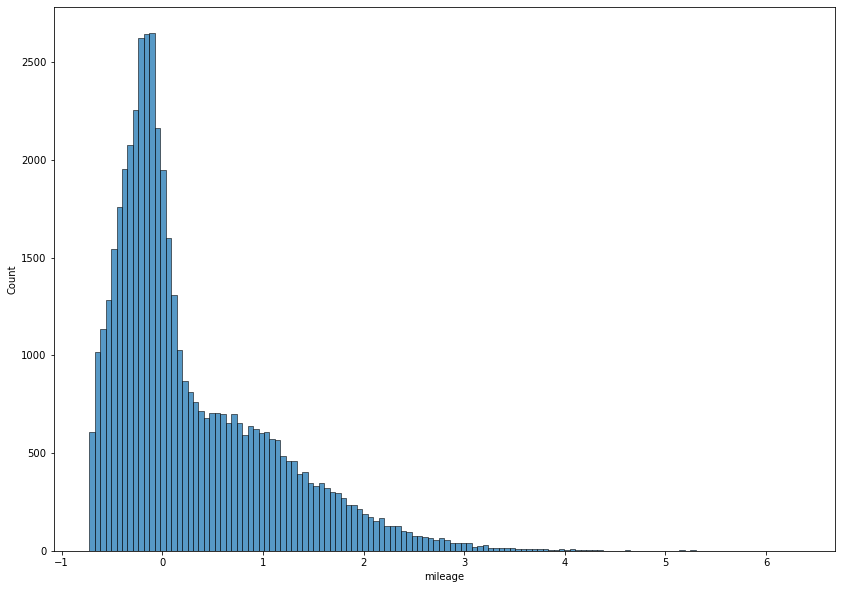

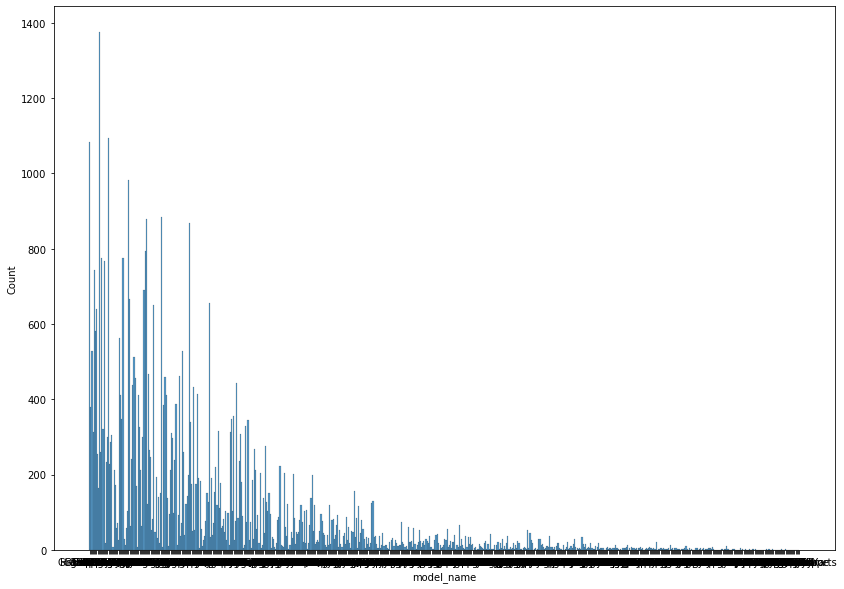

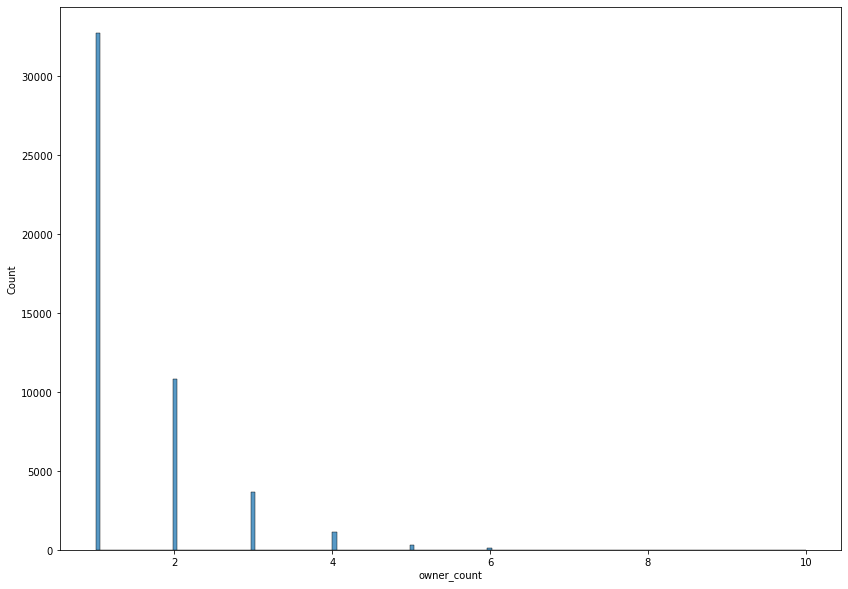

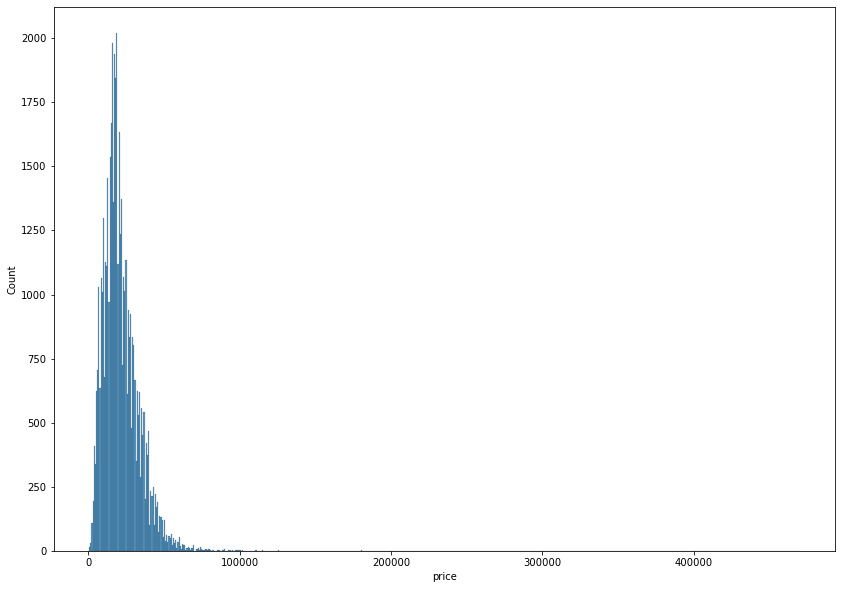

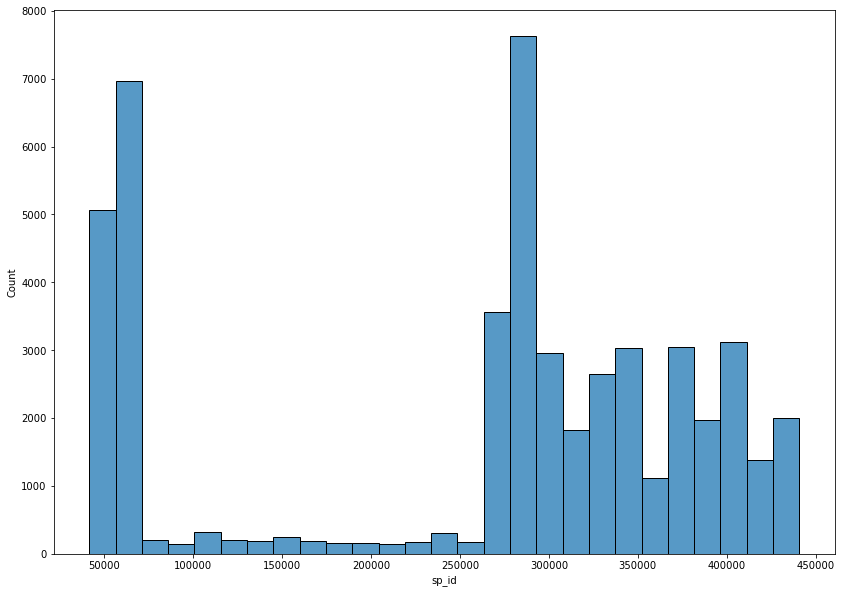

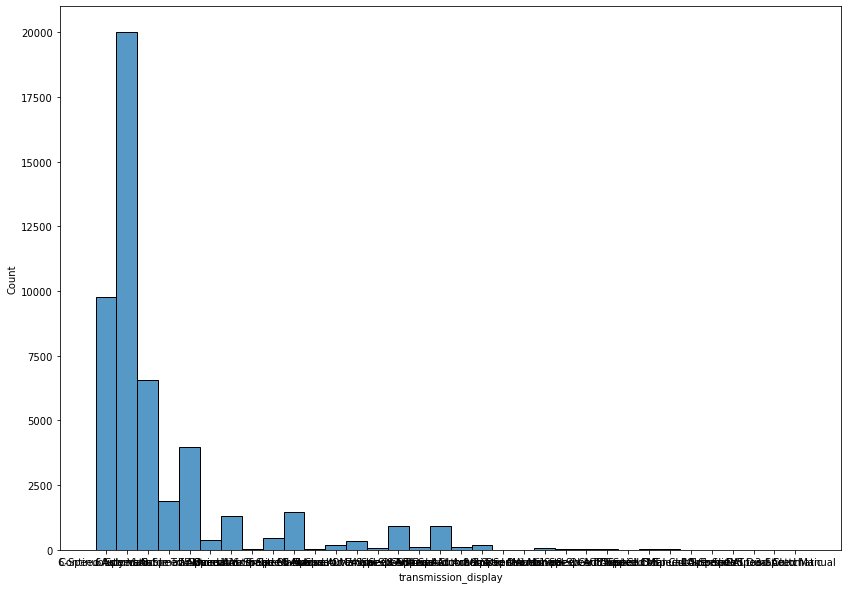

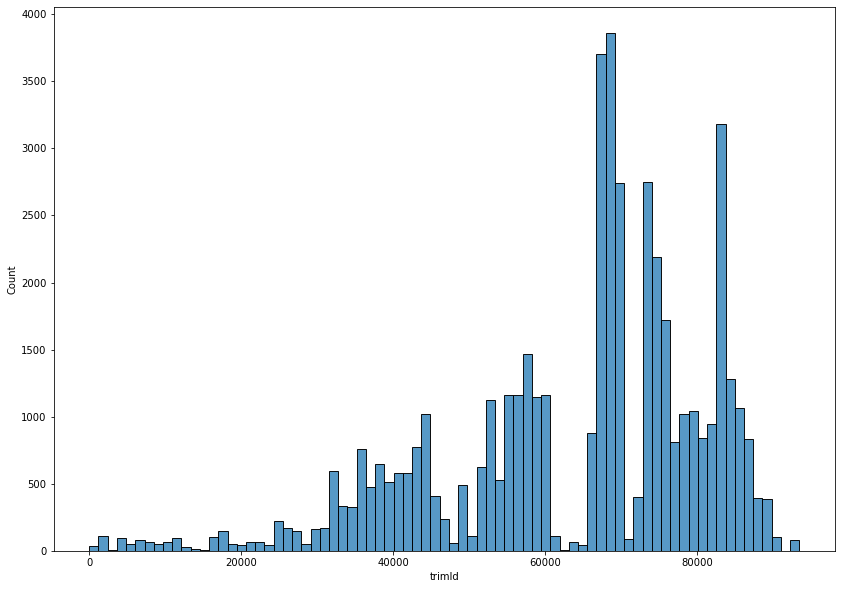

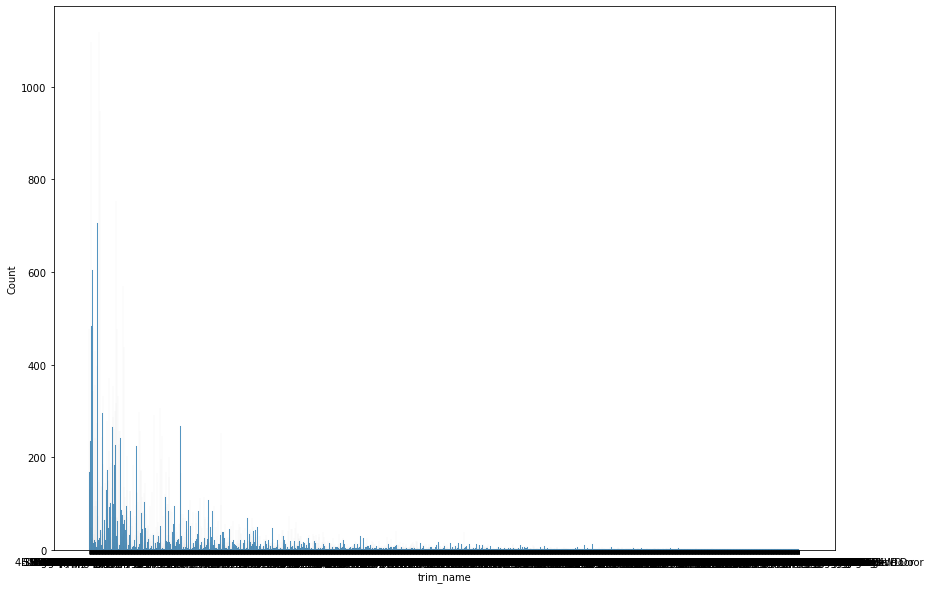

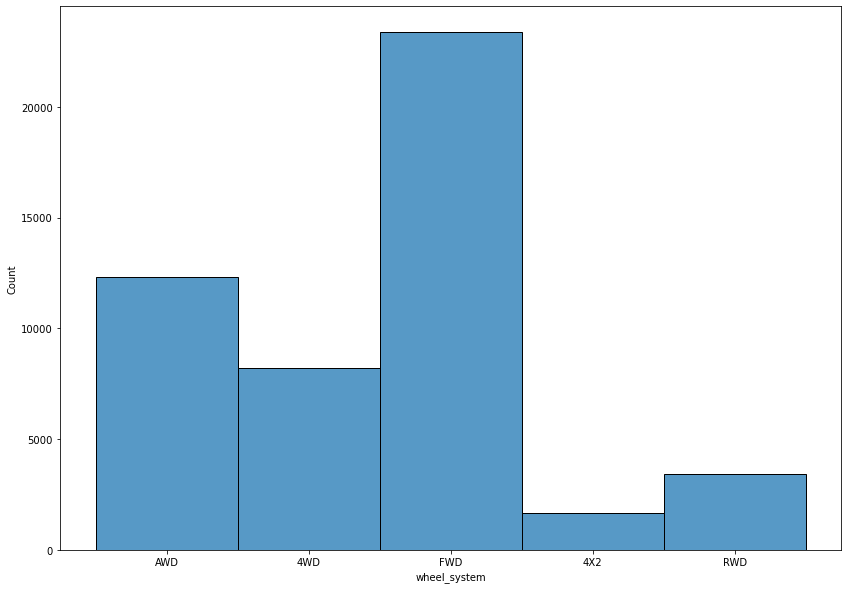

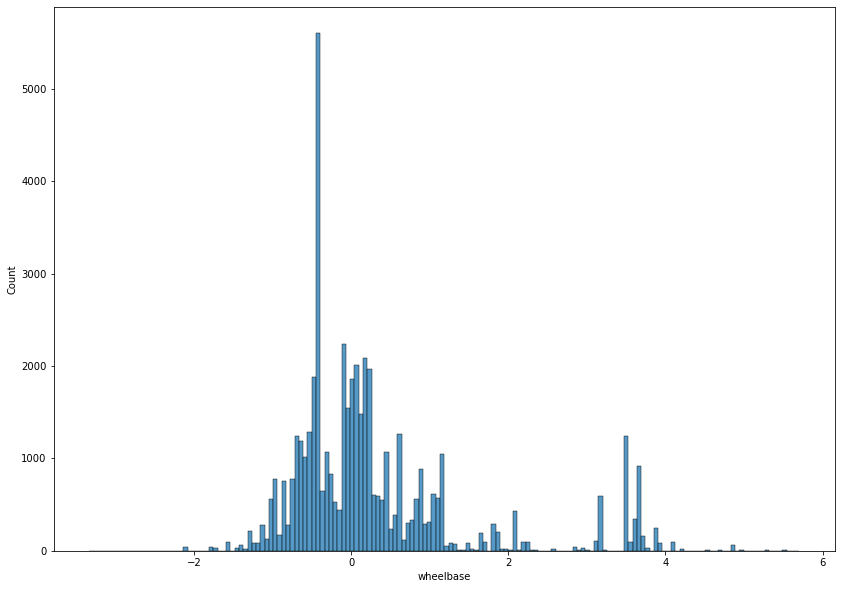

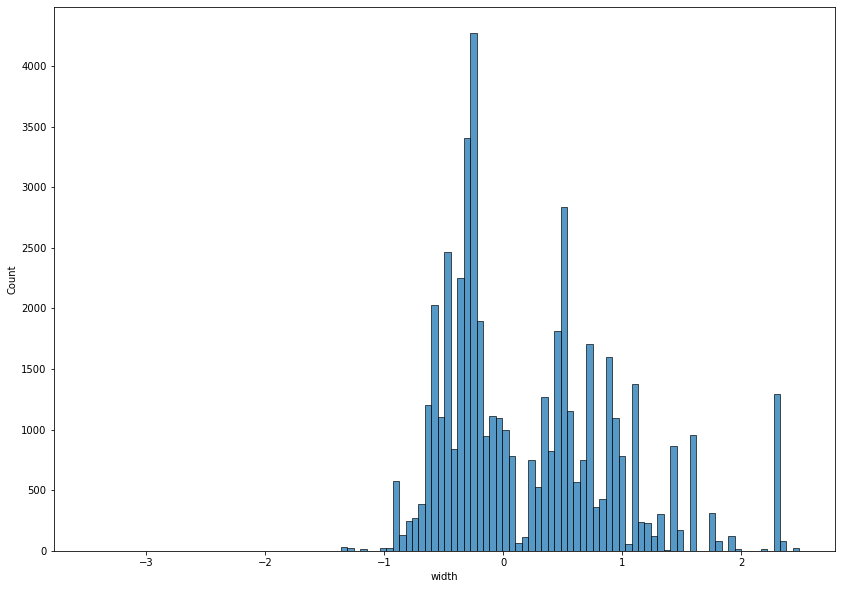

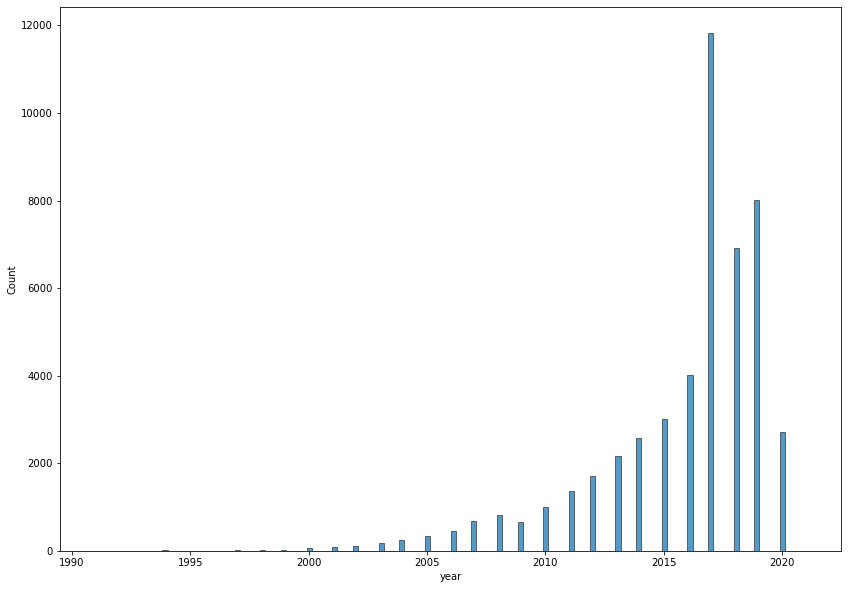

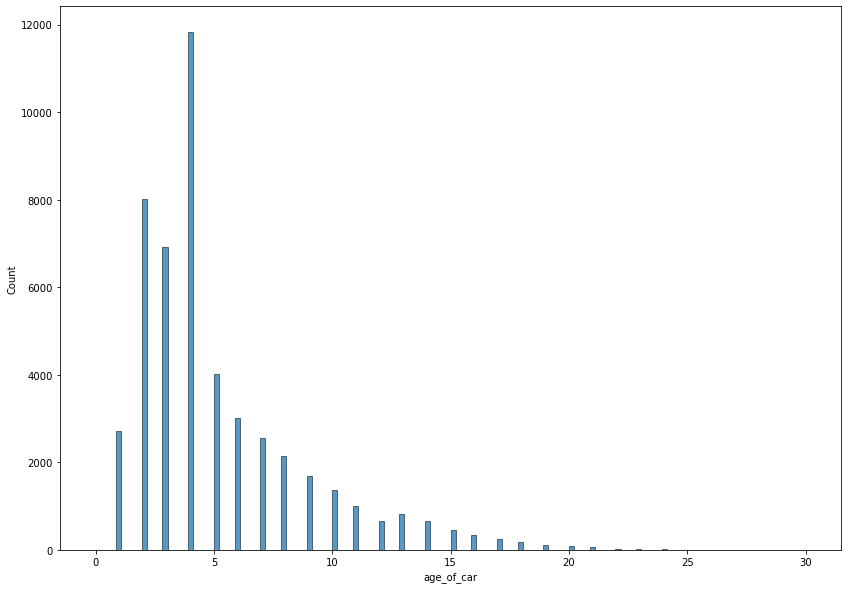

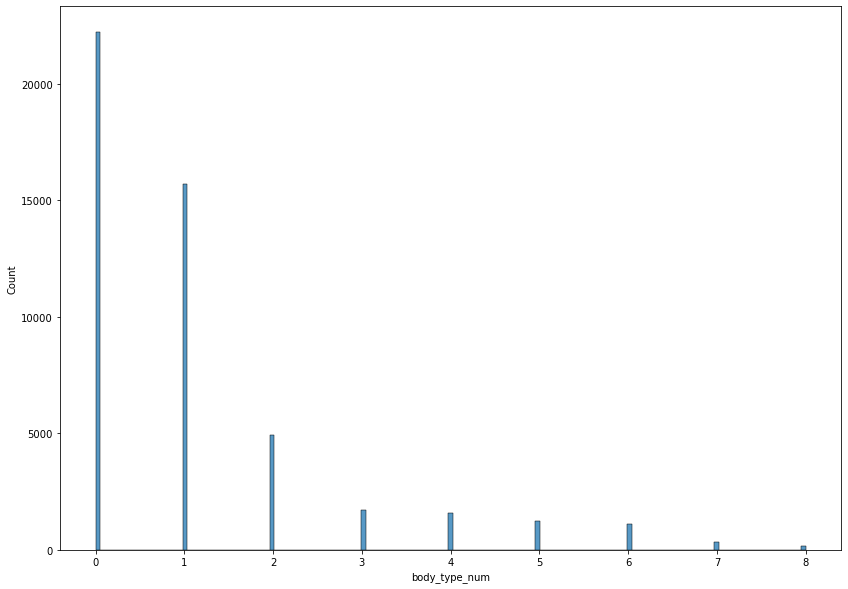

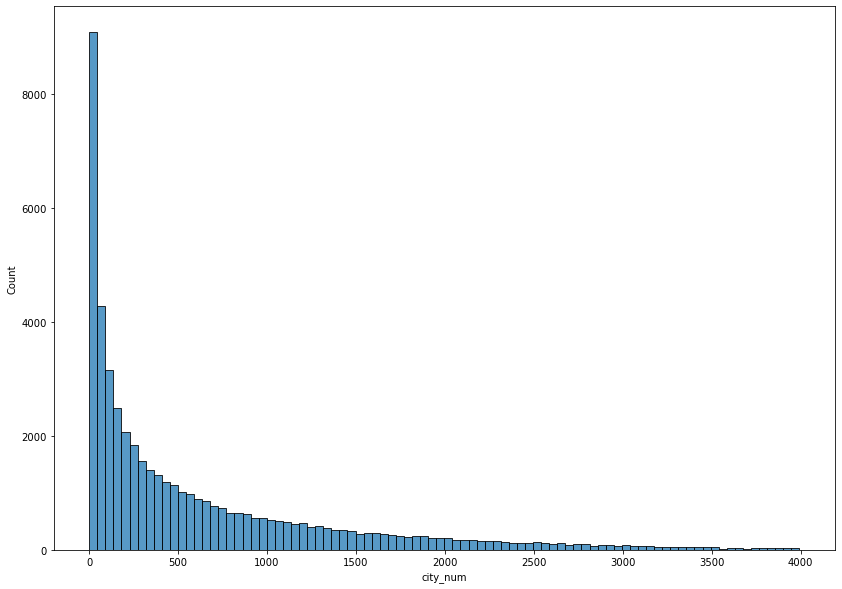

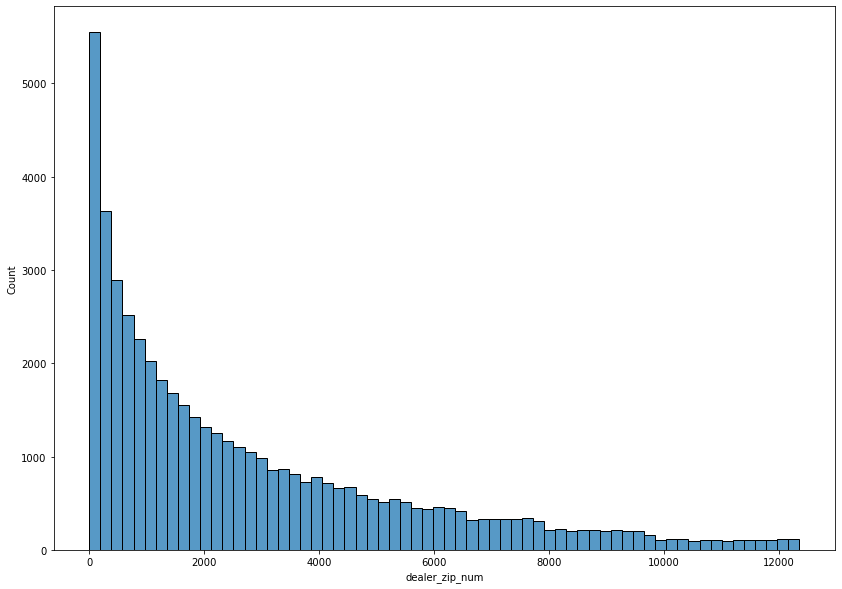

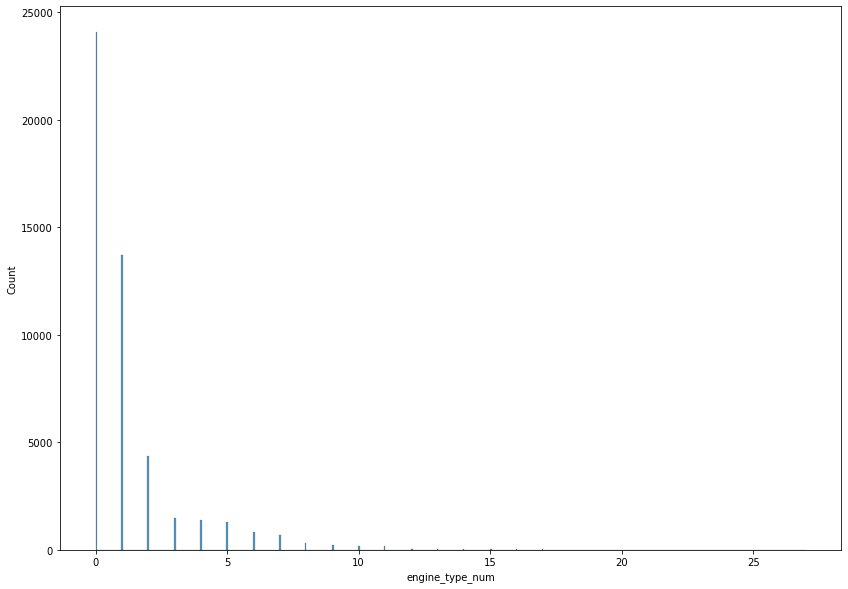

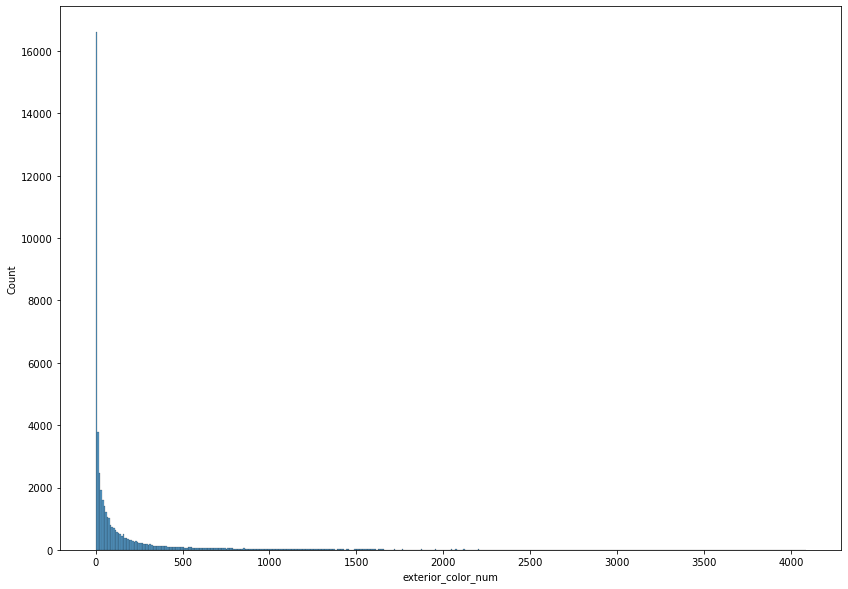

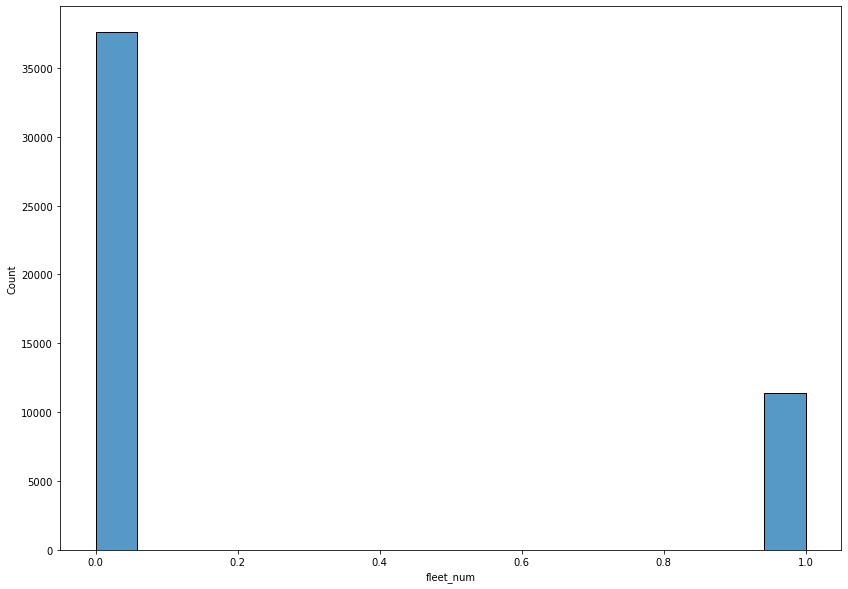

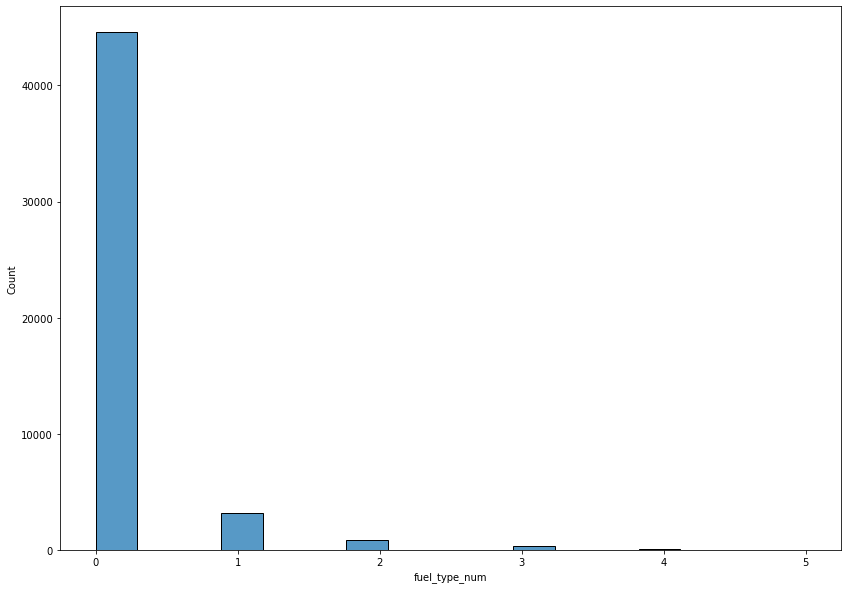

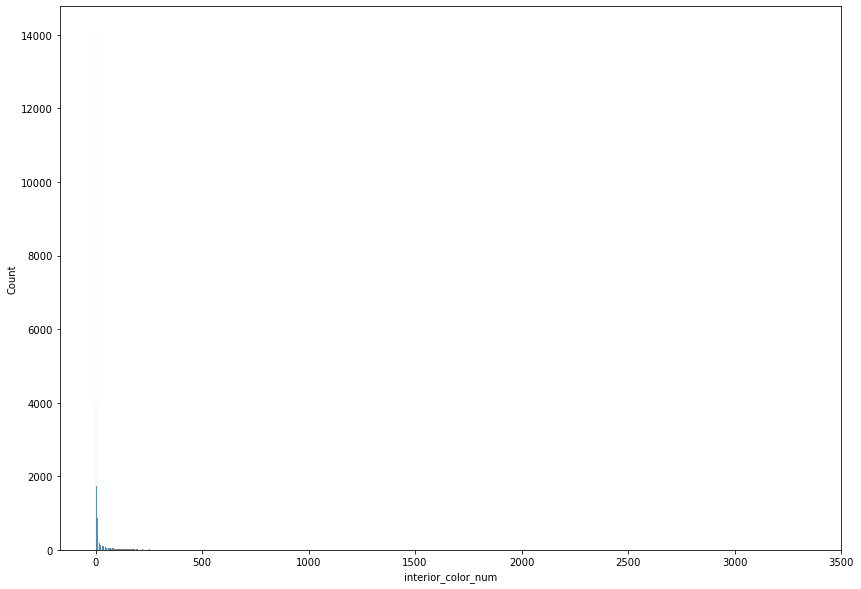

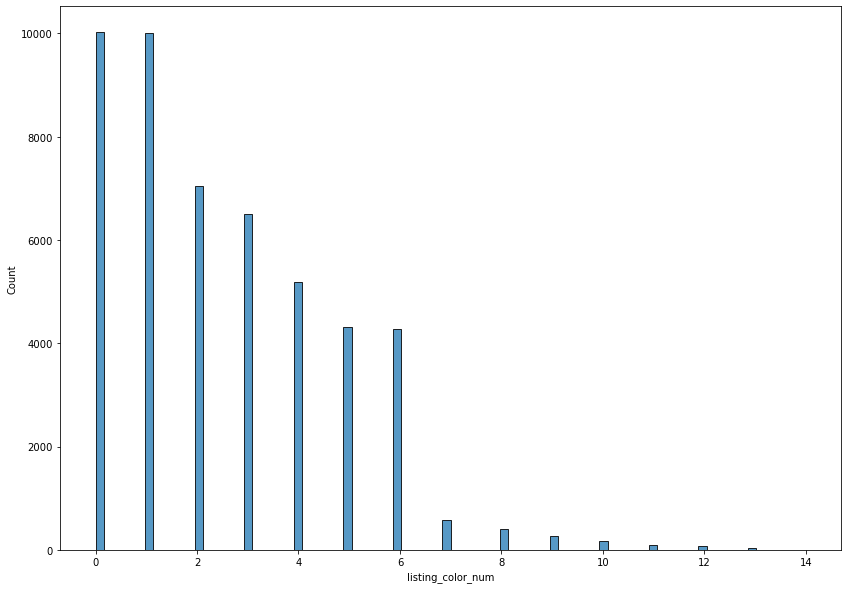

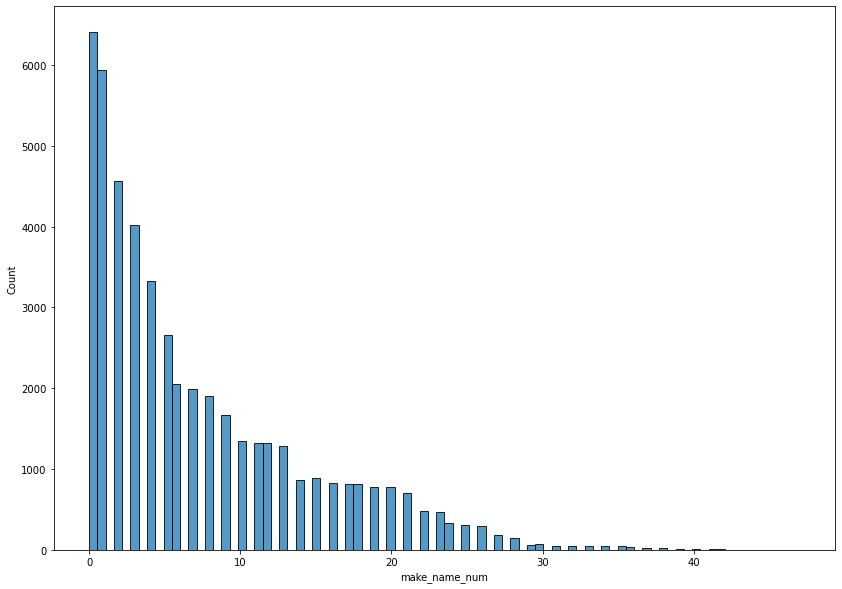

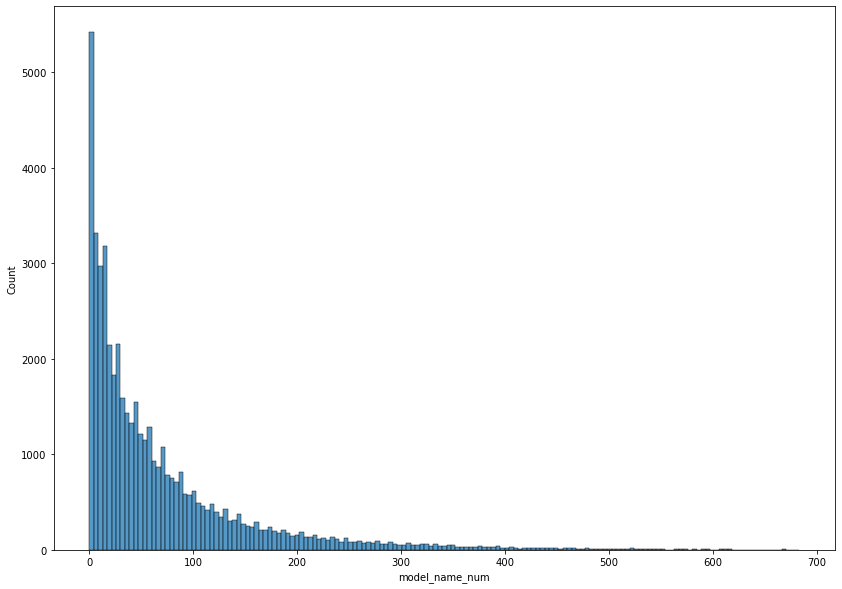

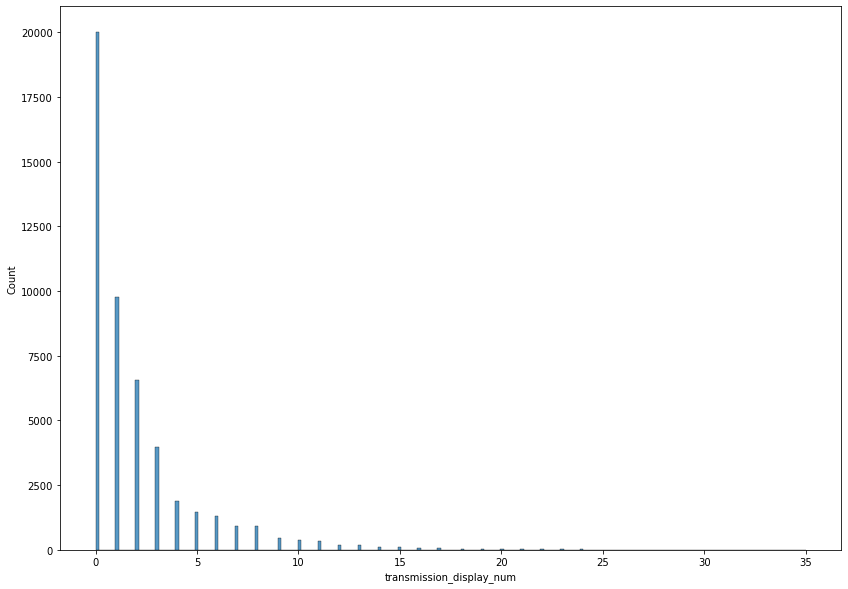

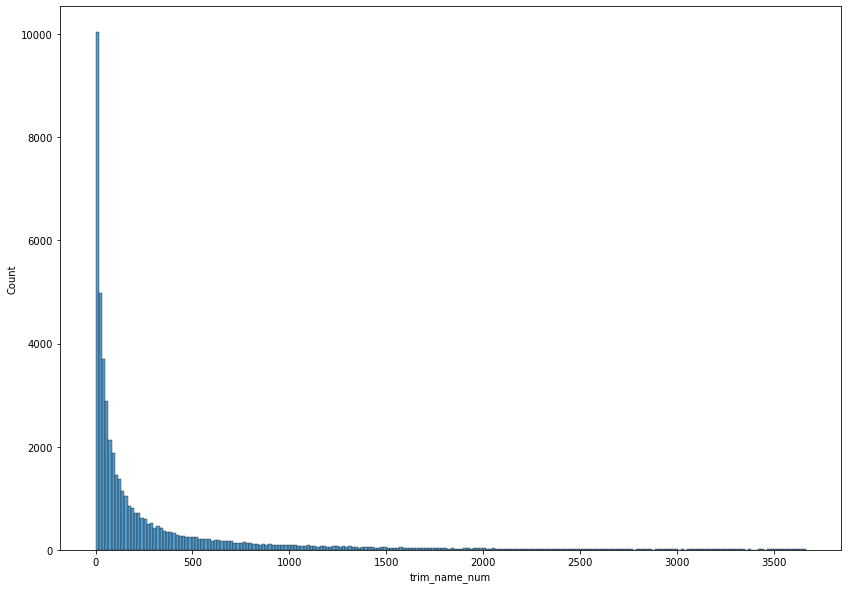

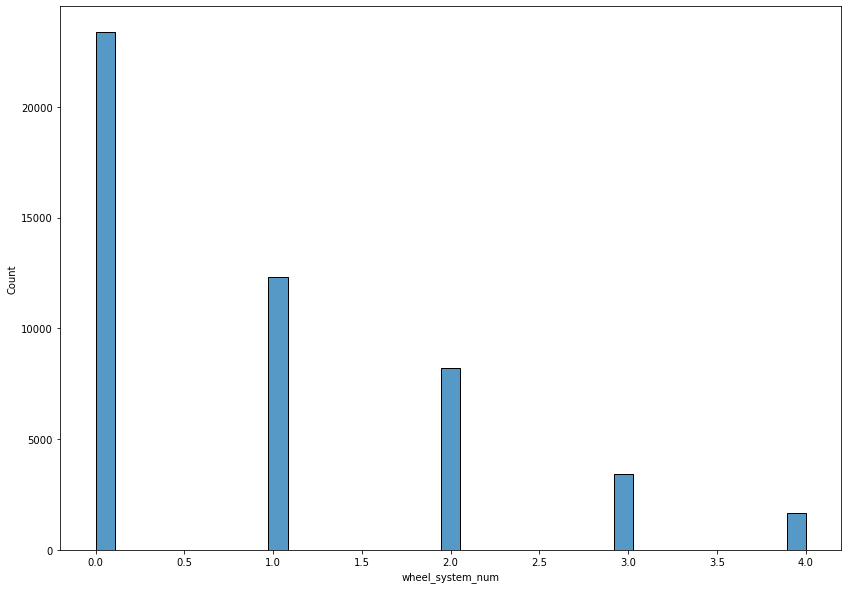

In [7]:
explore.get_distribution(train_scaled.drop(columns=['vin','city','dealer_zip']))

### Target = Price

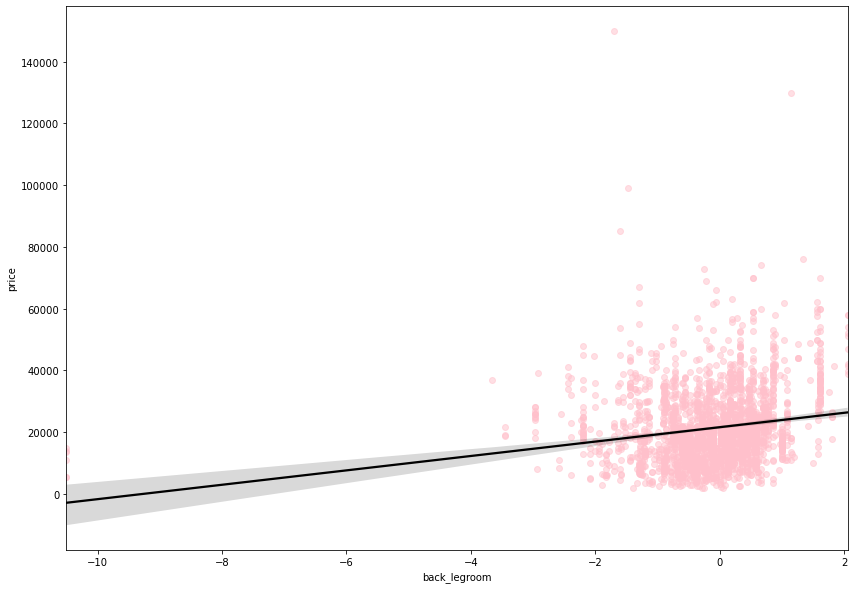

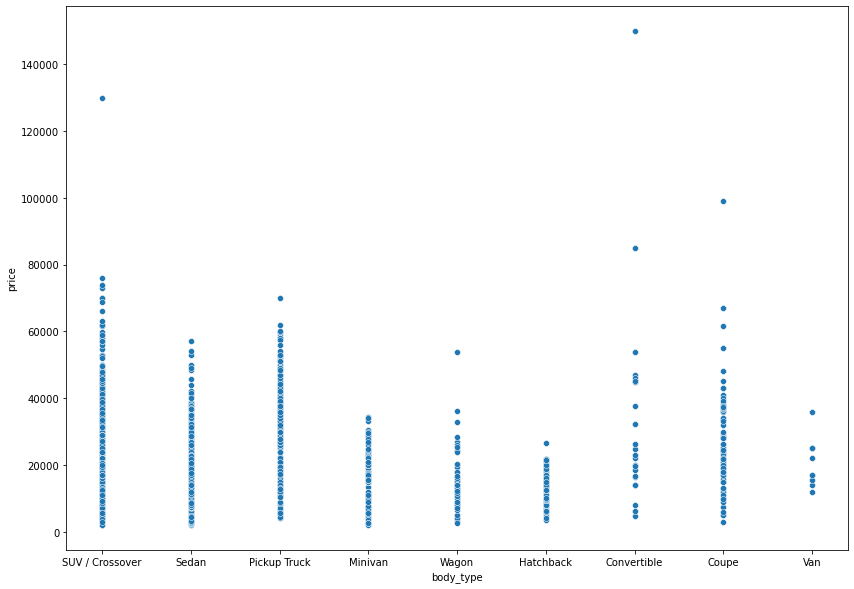

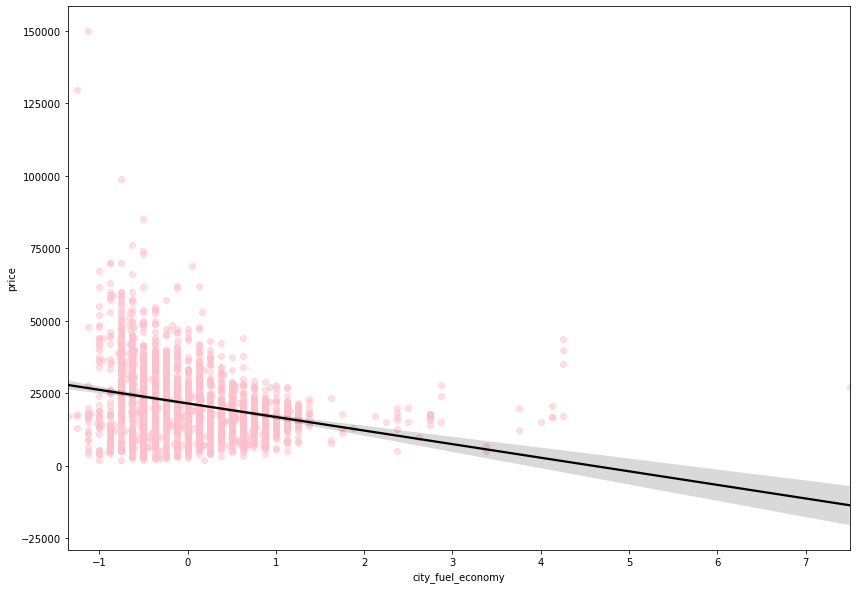

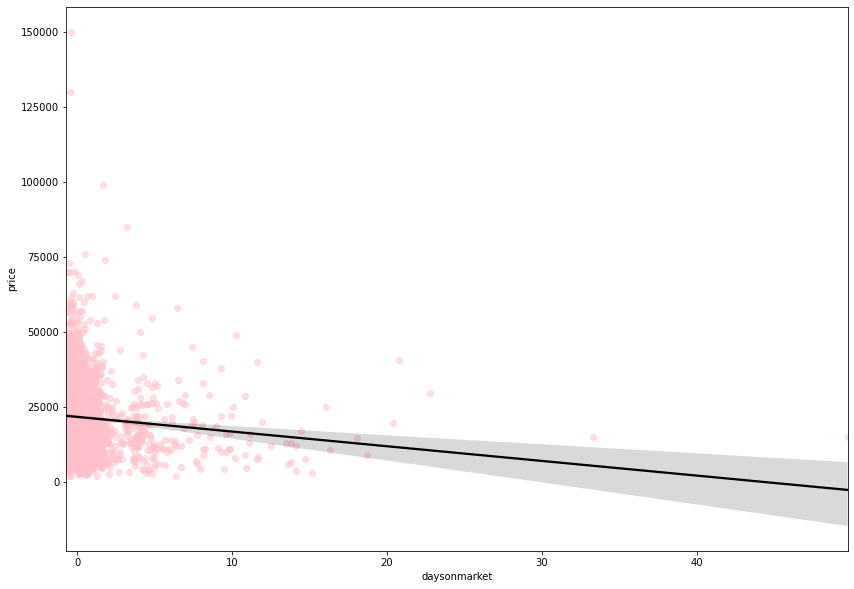

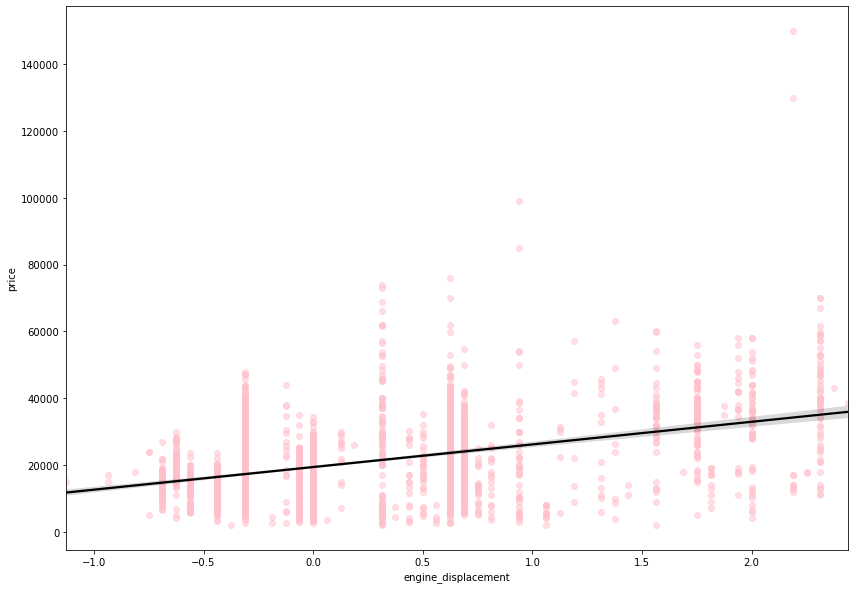

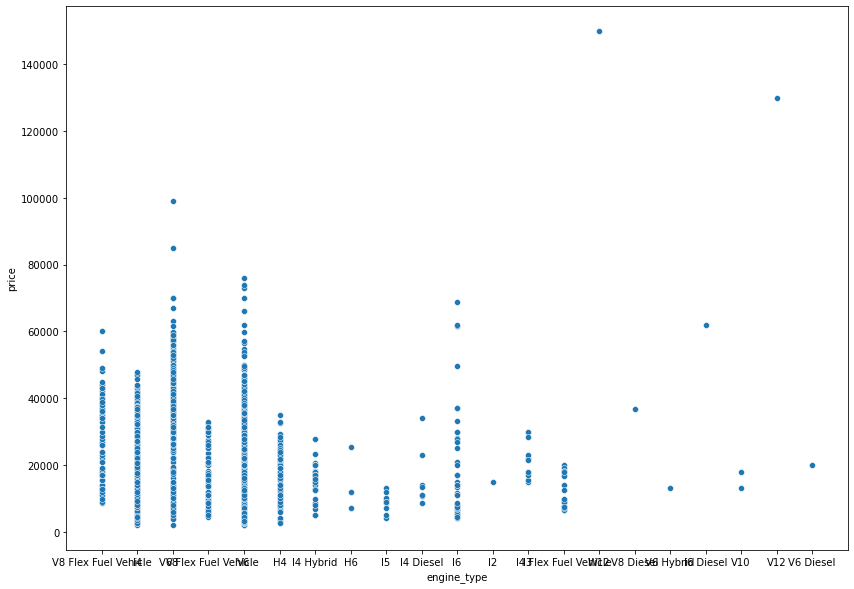

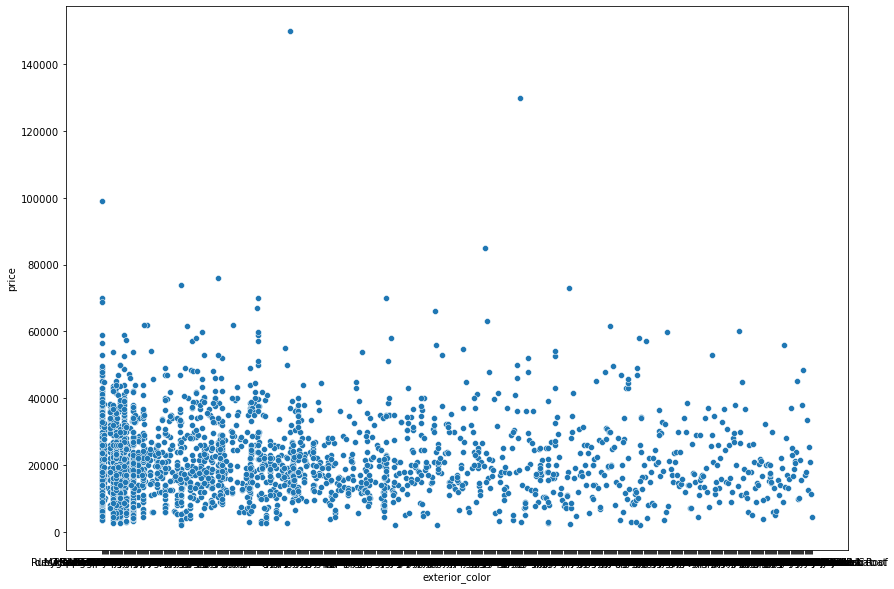

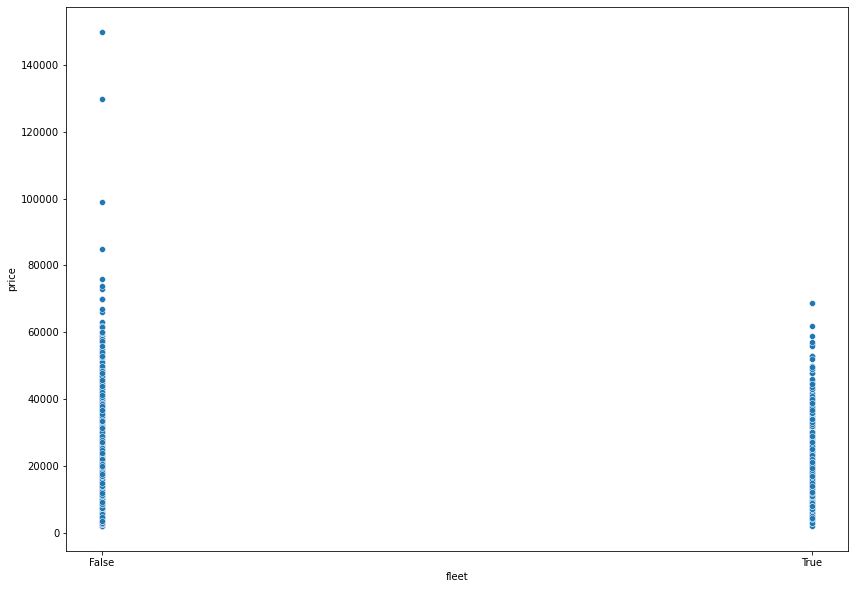

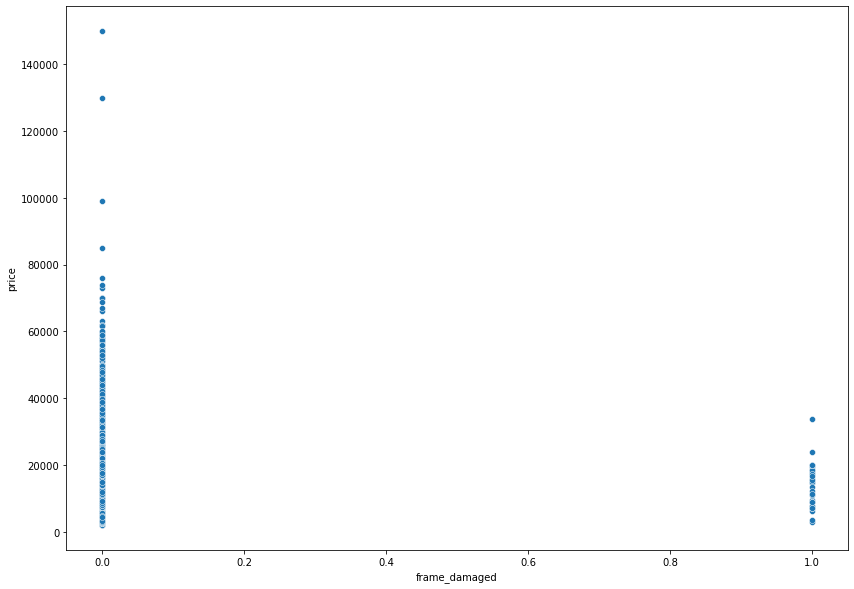

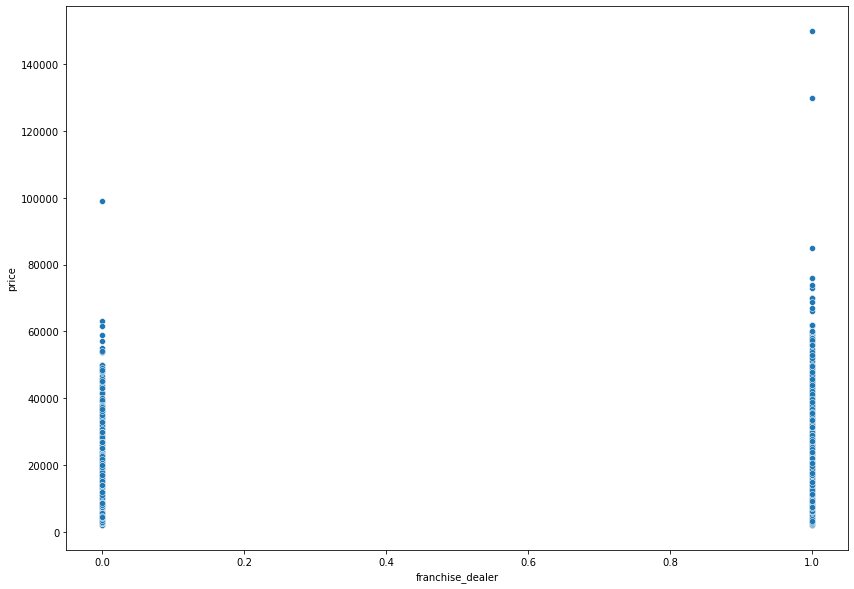

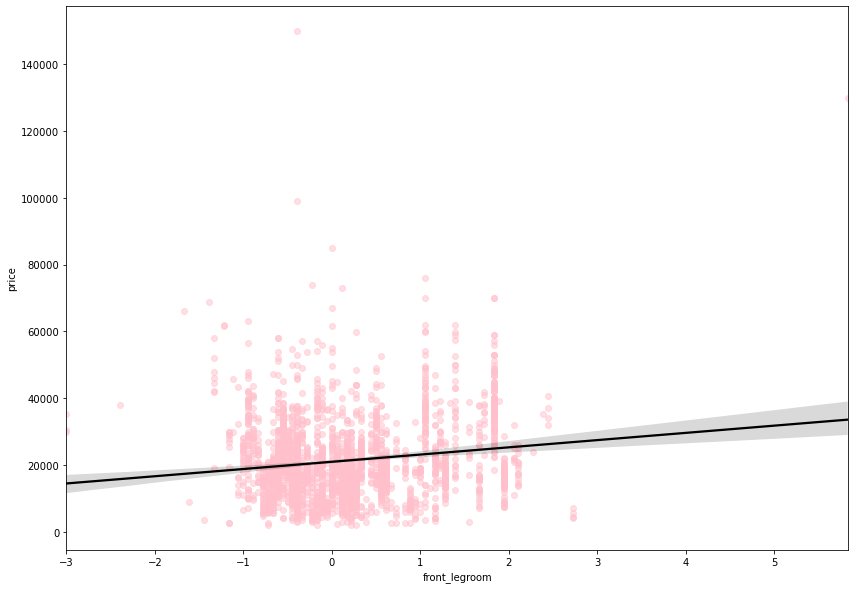

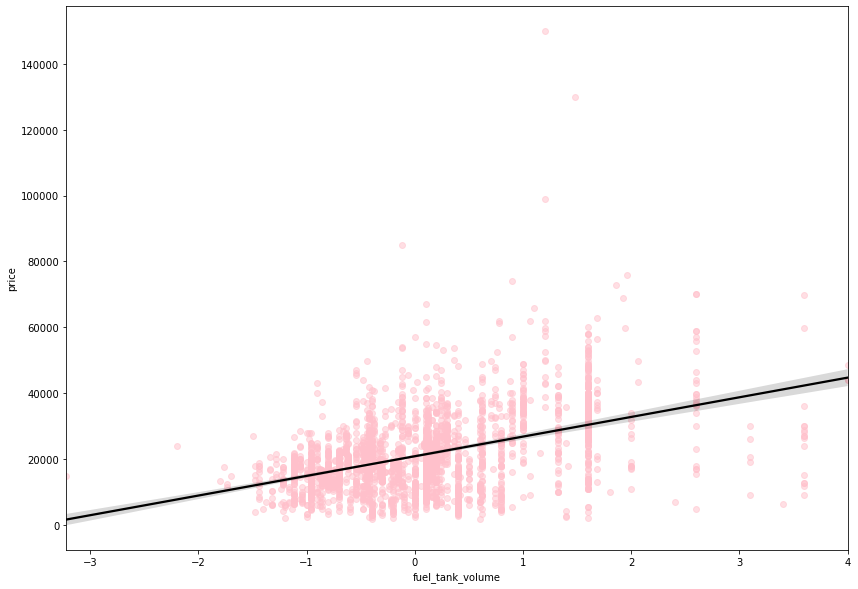

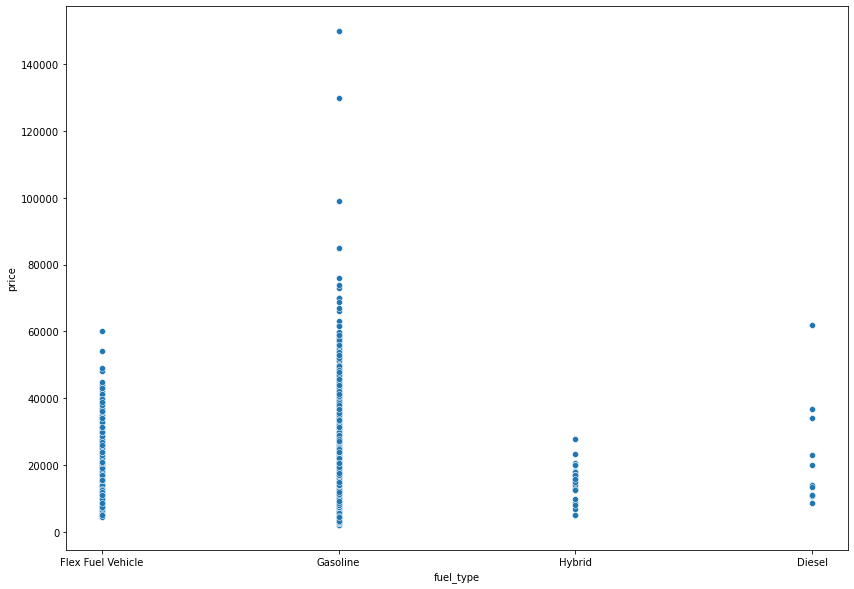

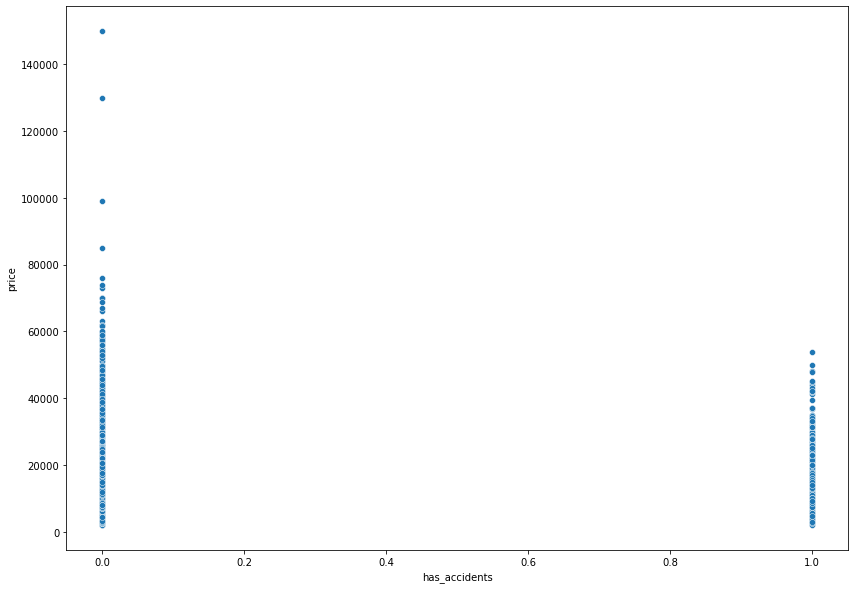

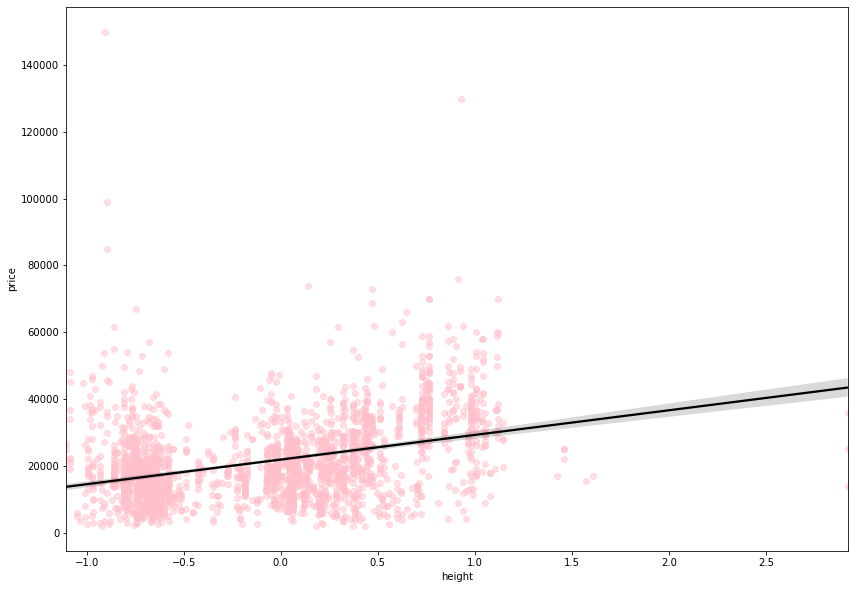

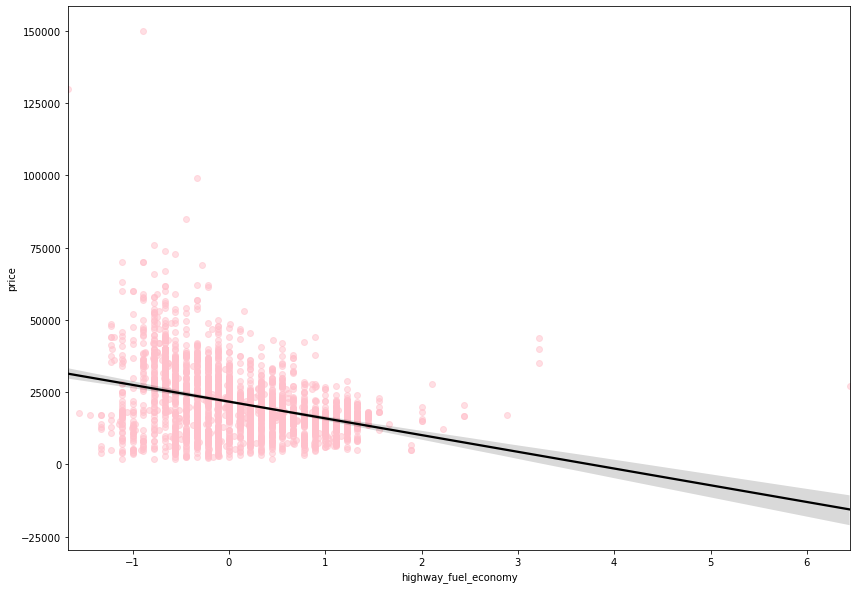

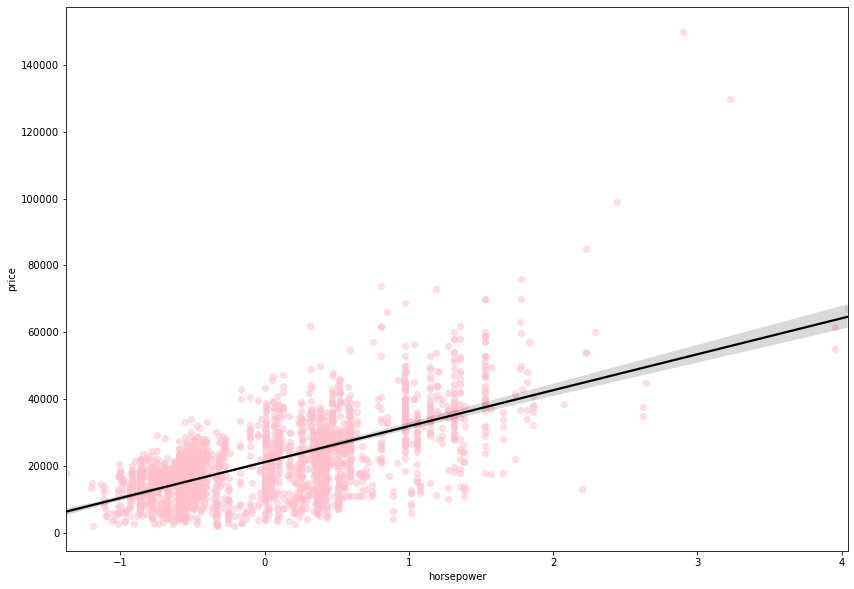

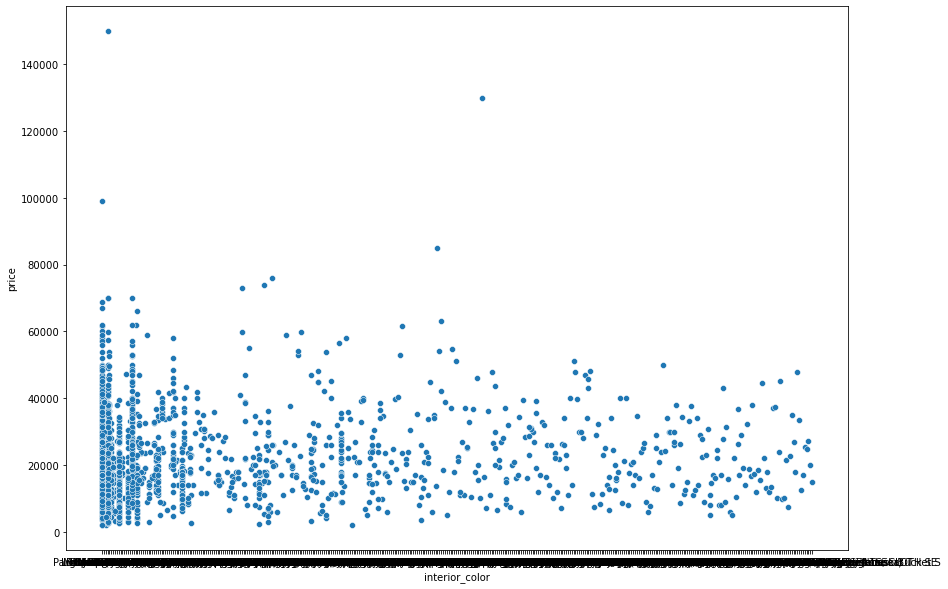

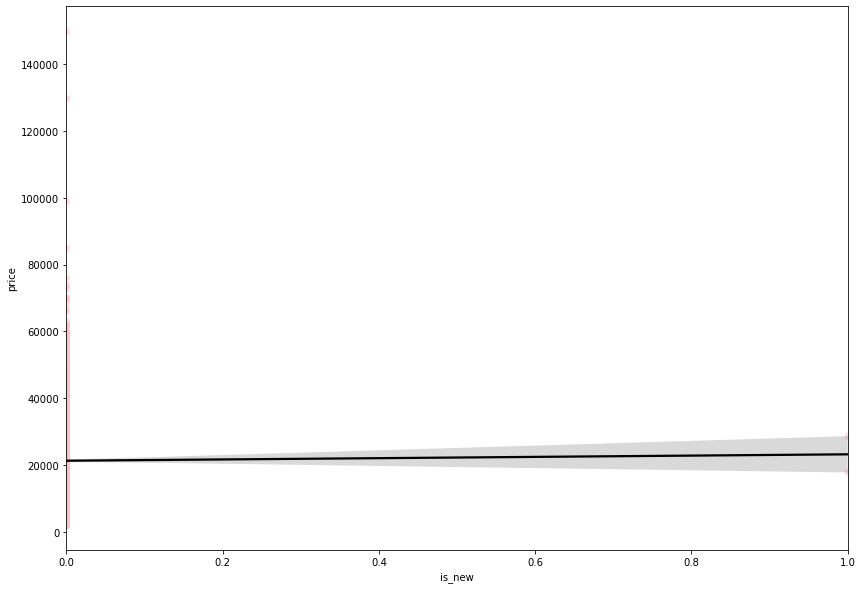

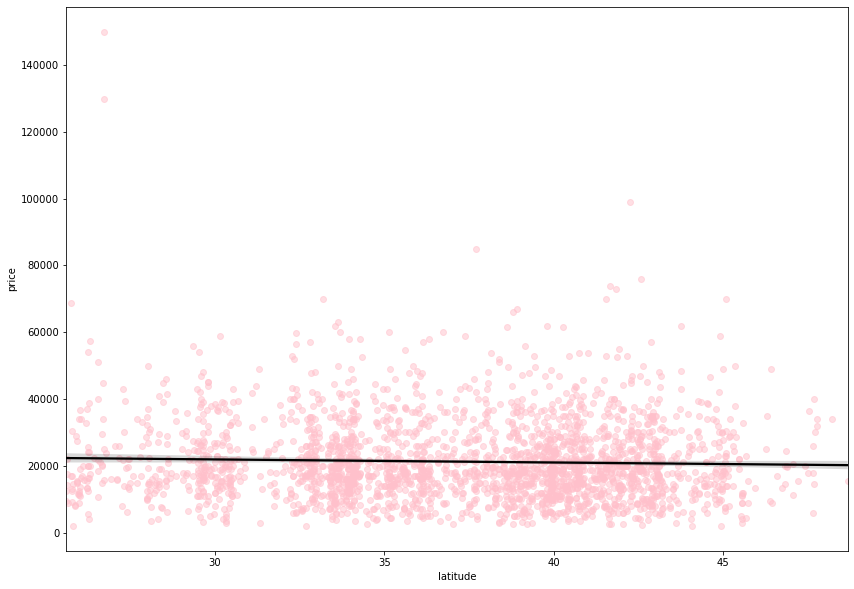

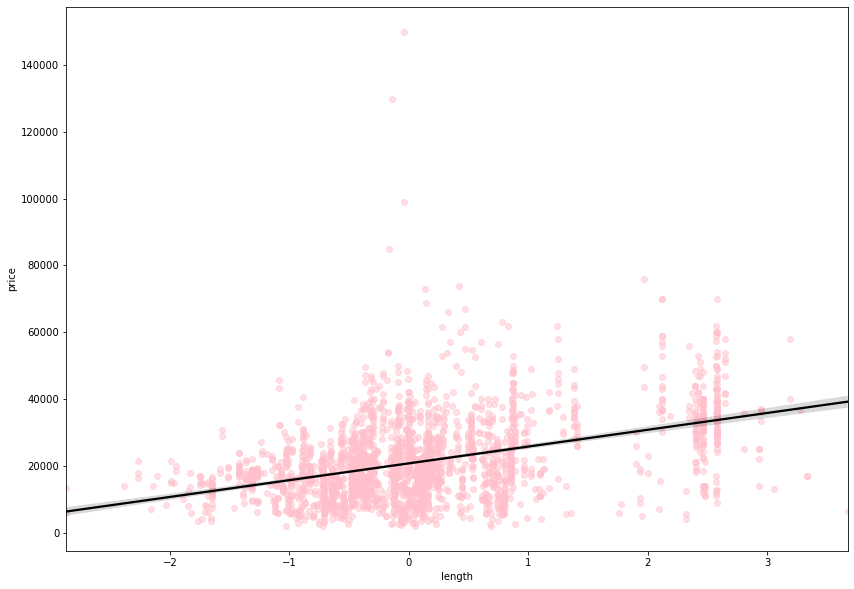

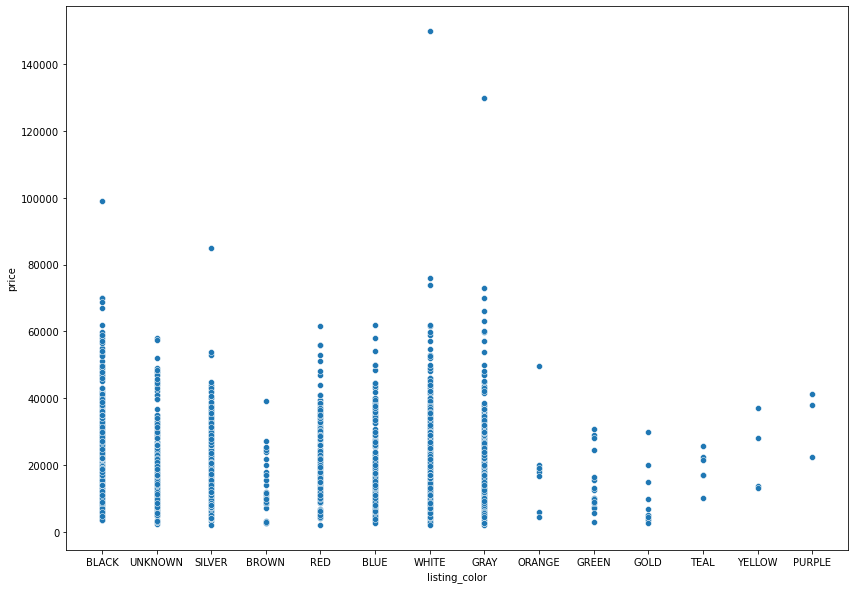

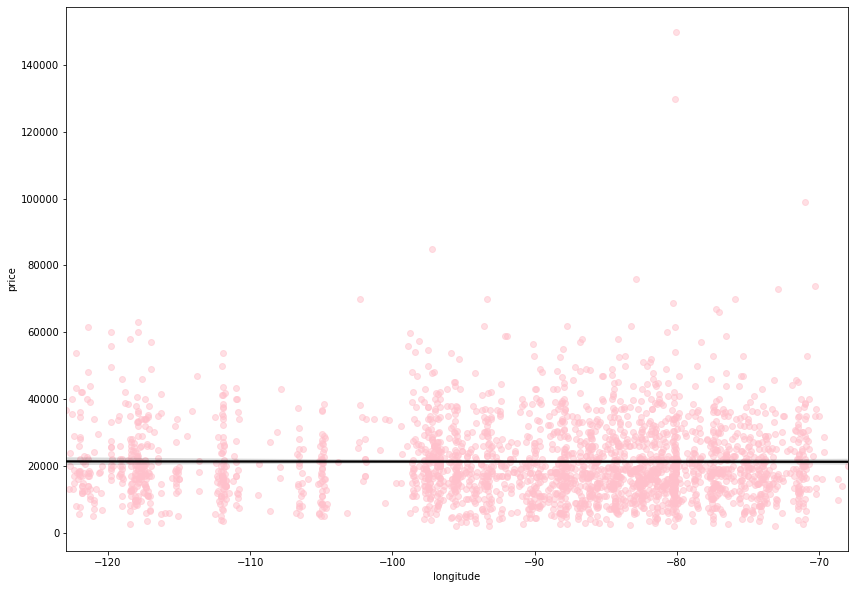

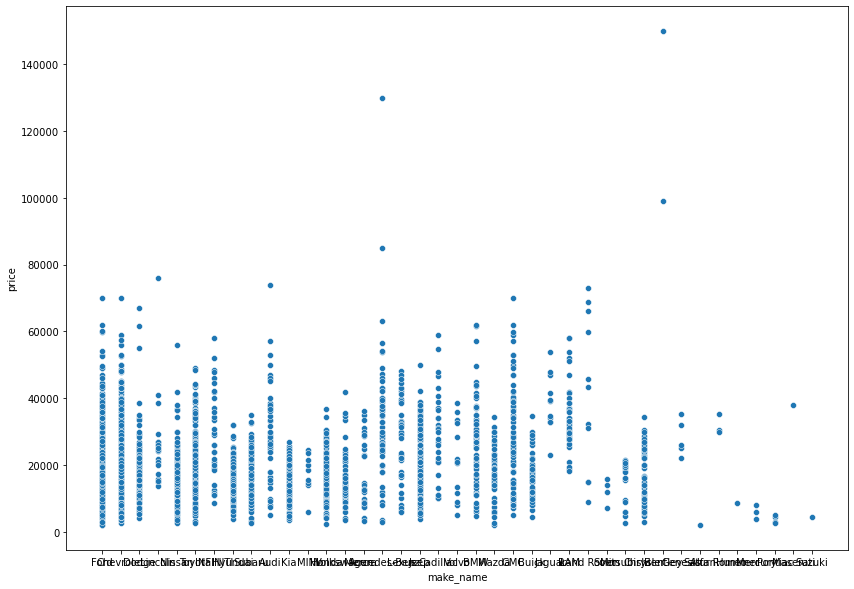

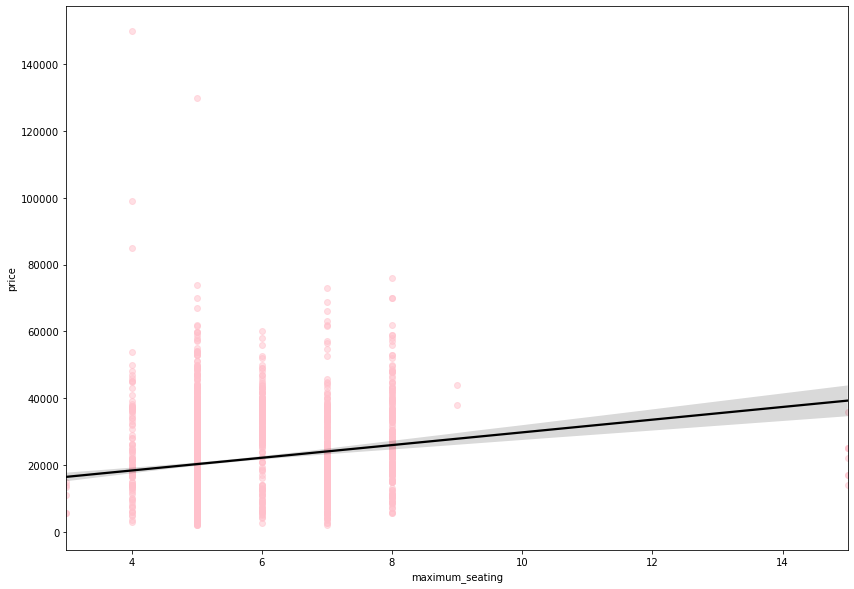

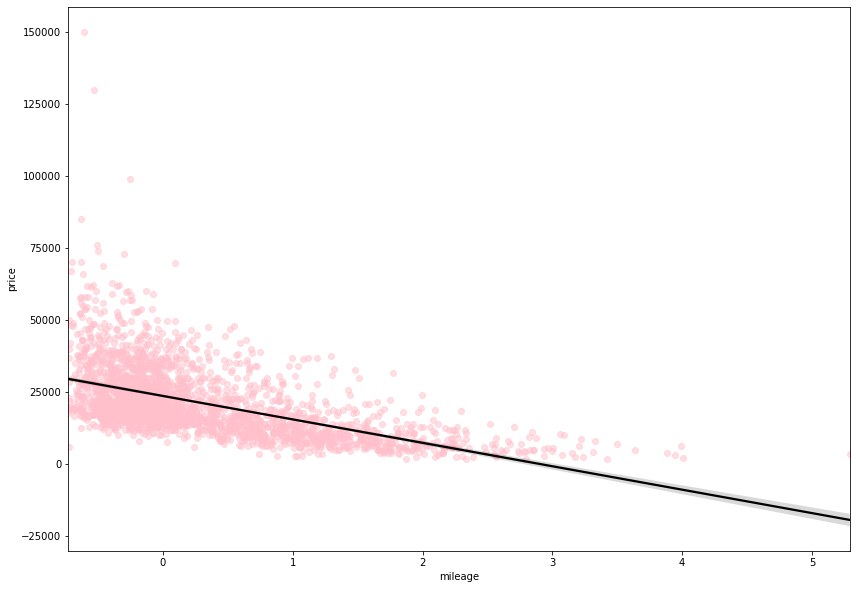

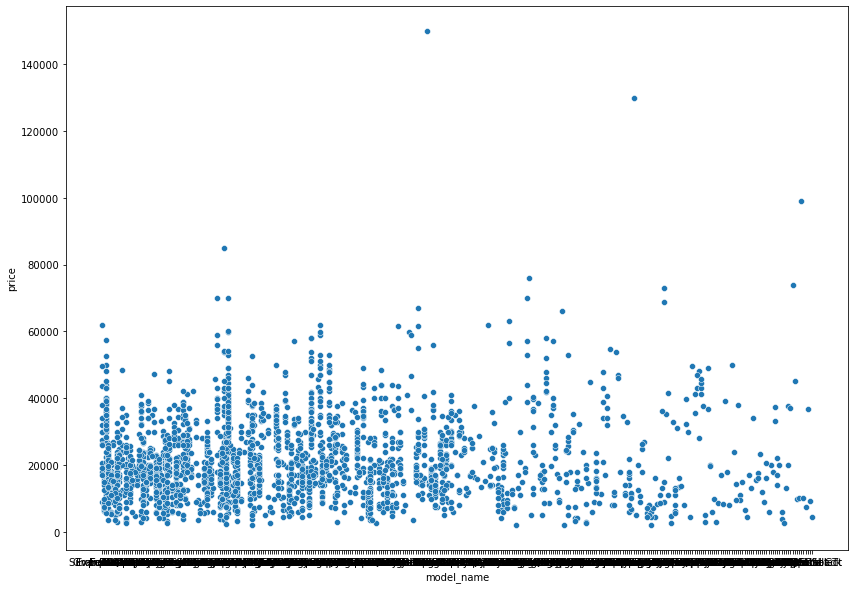

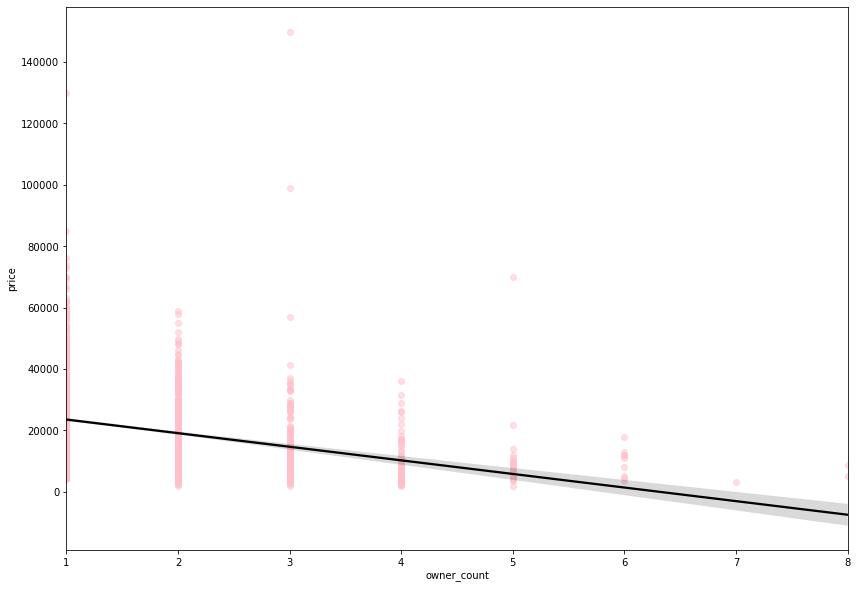

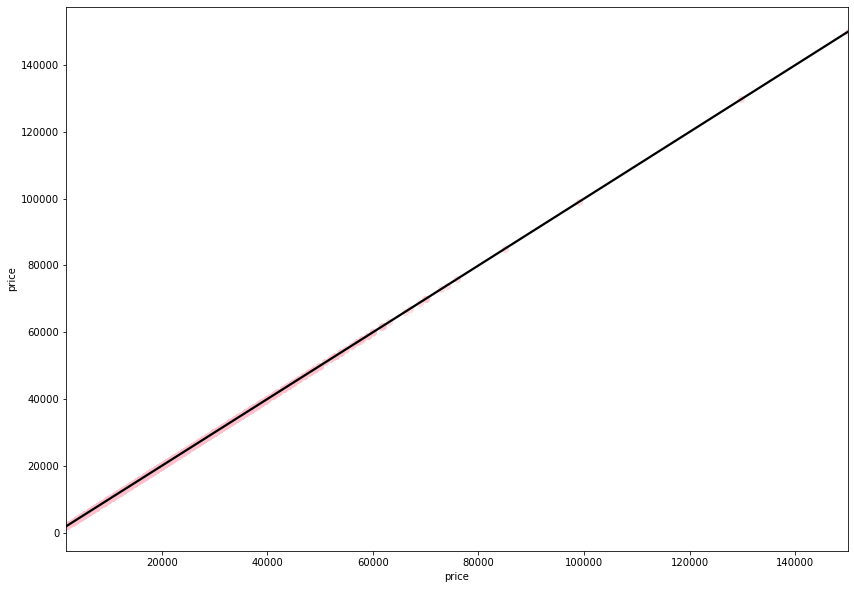

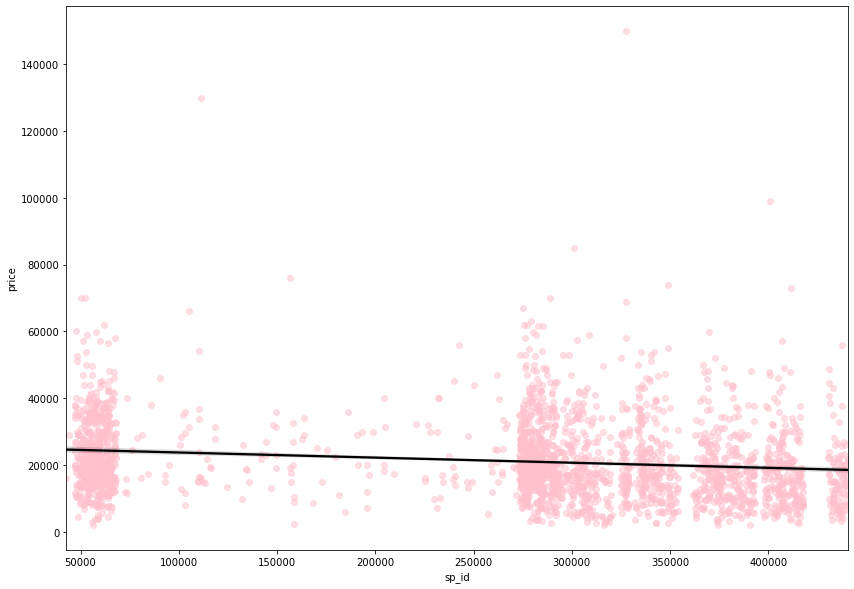

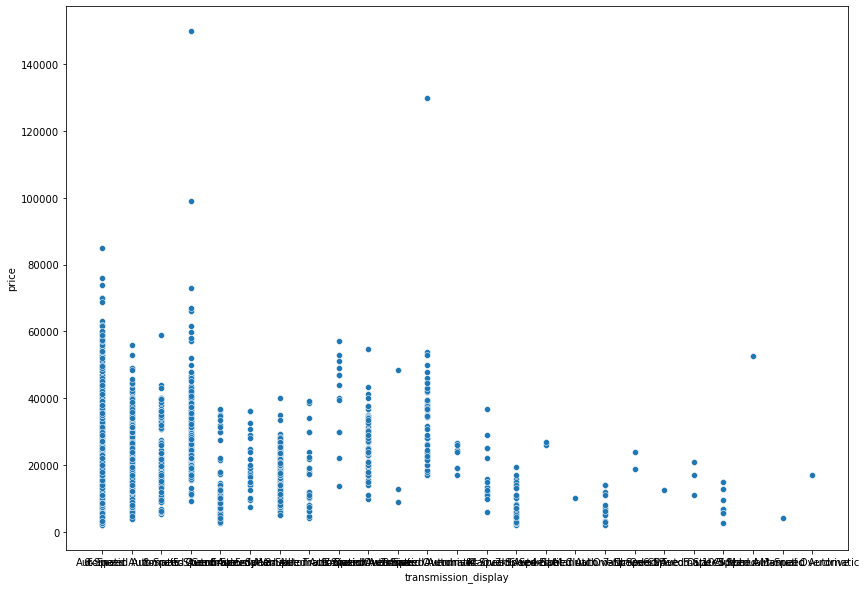

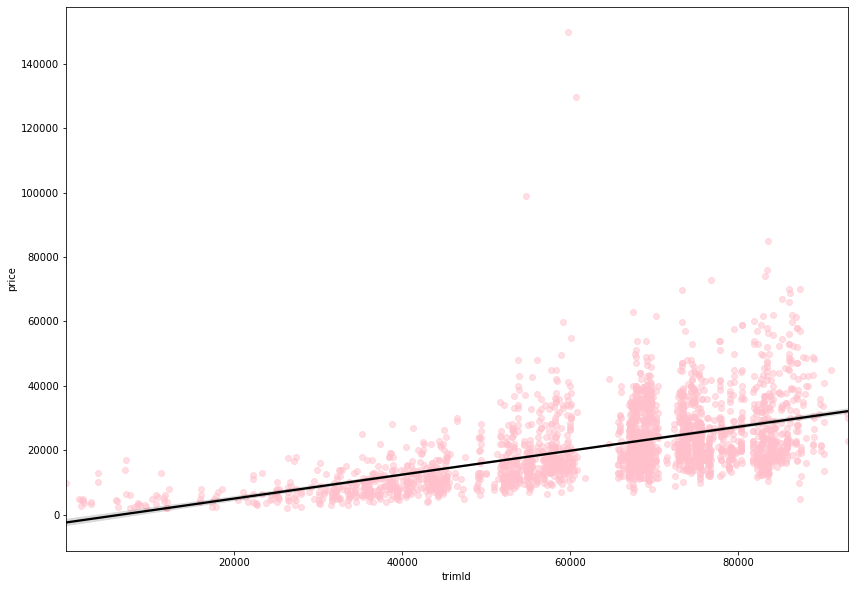

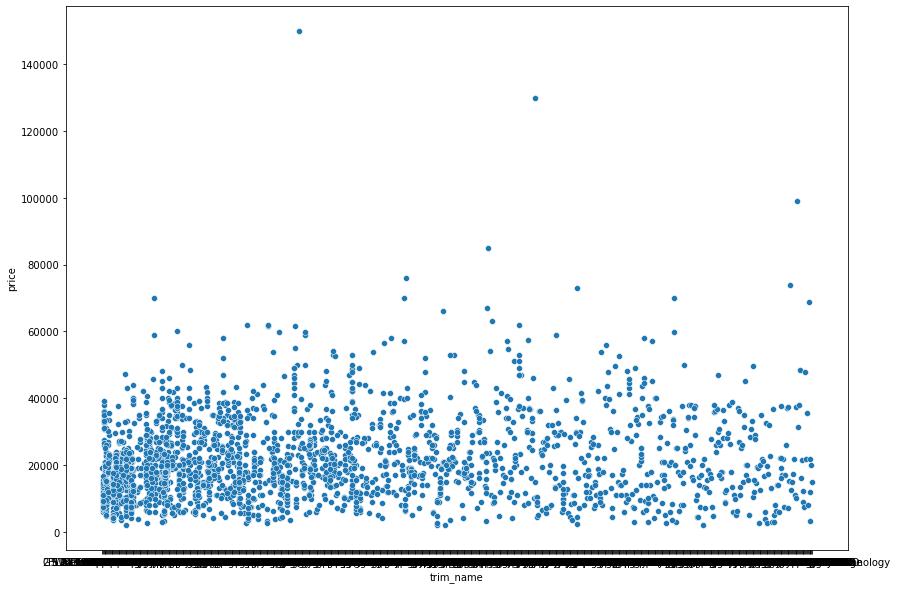

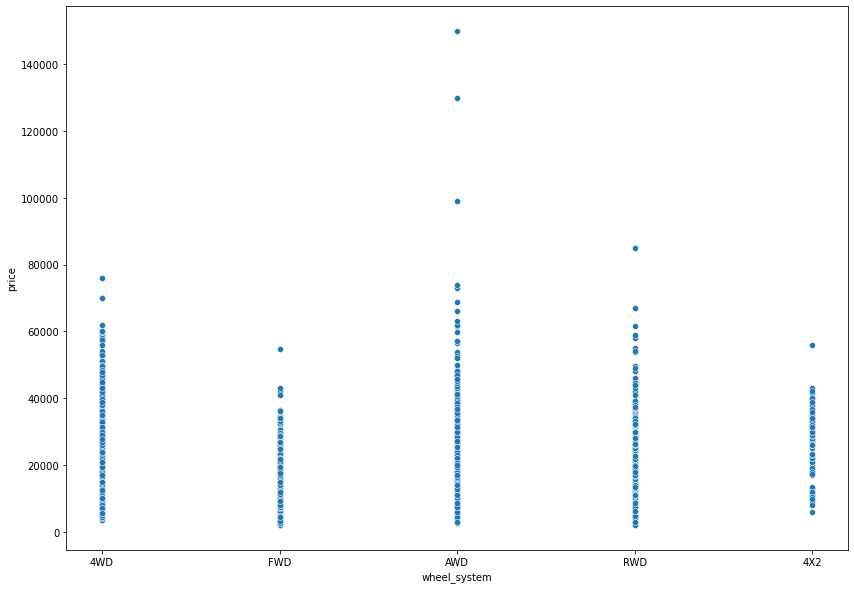

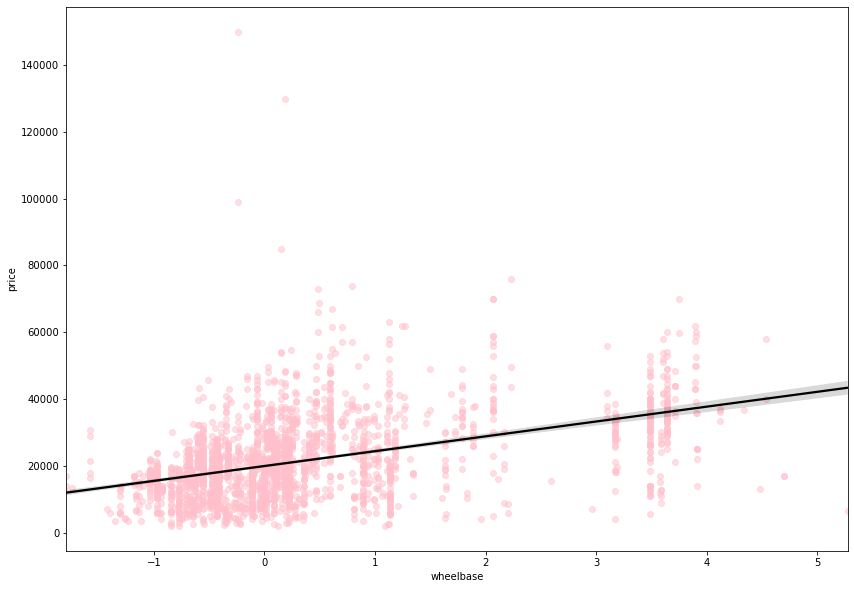

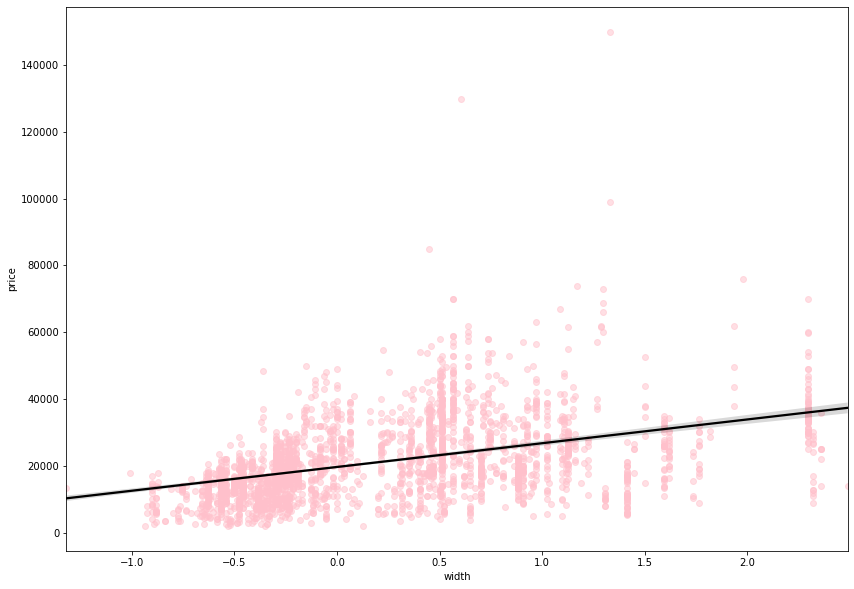

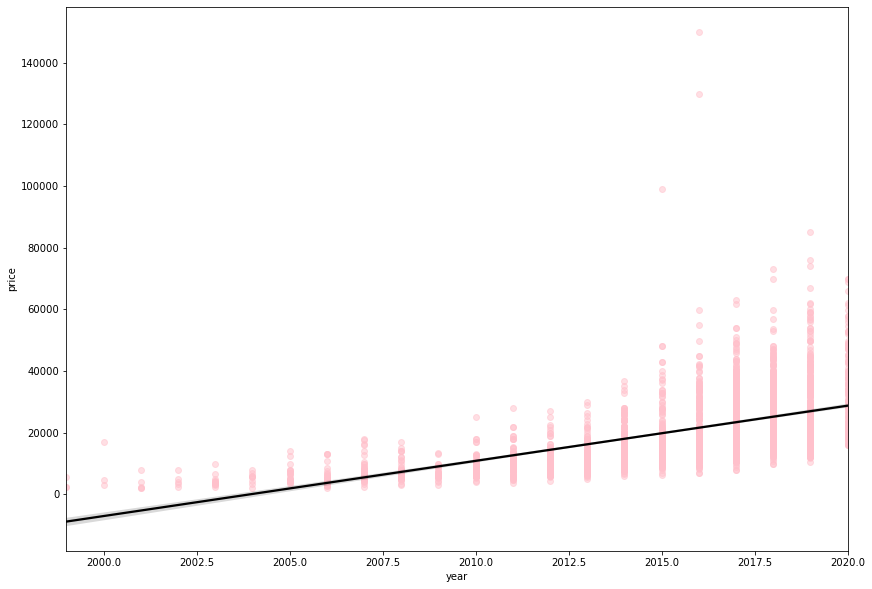

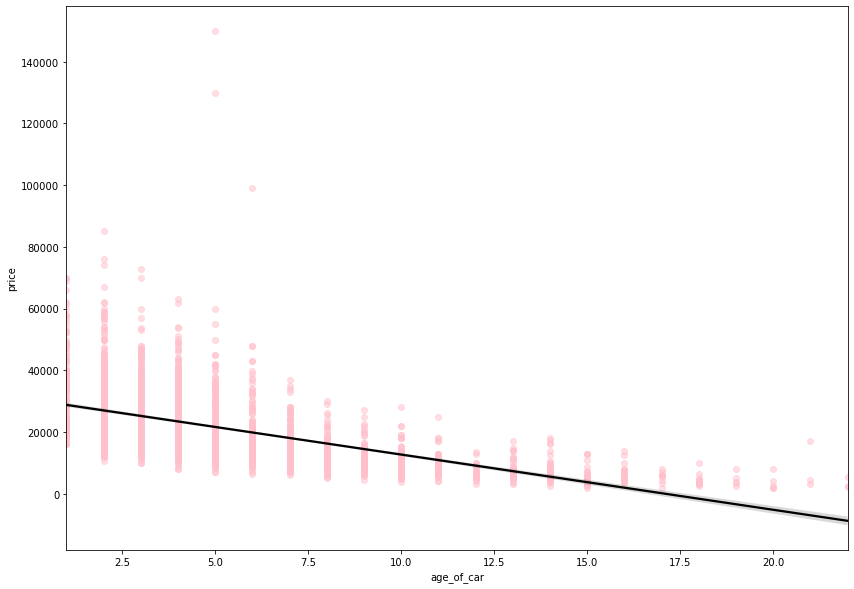

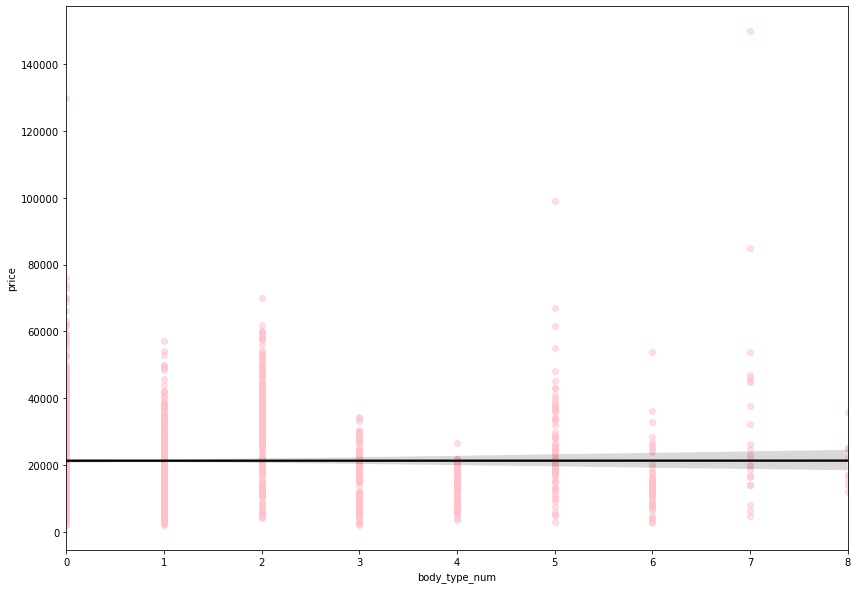

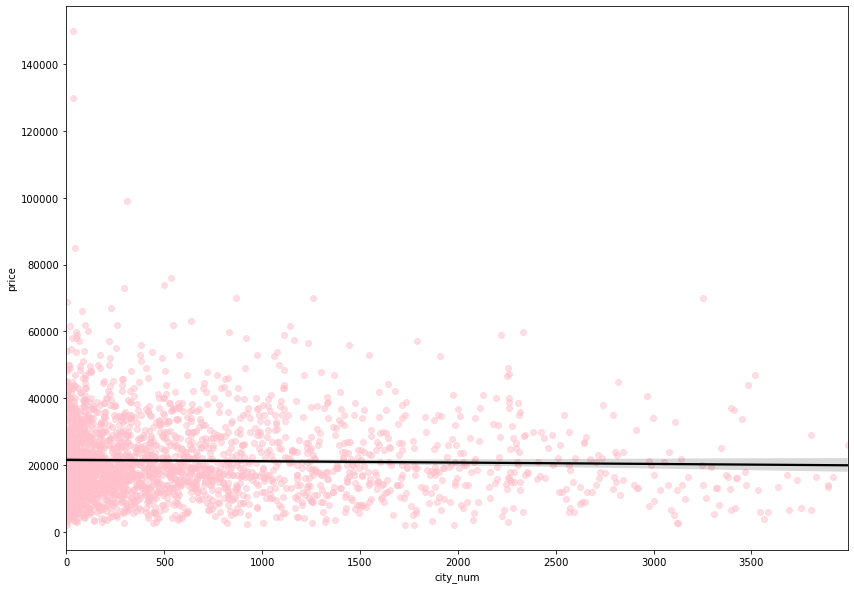

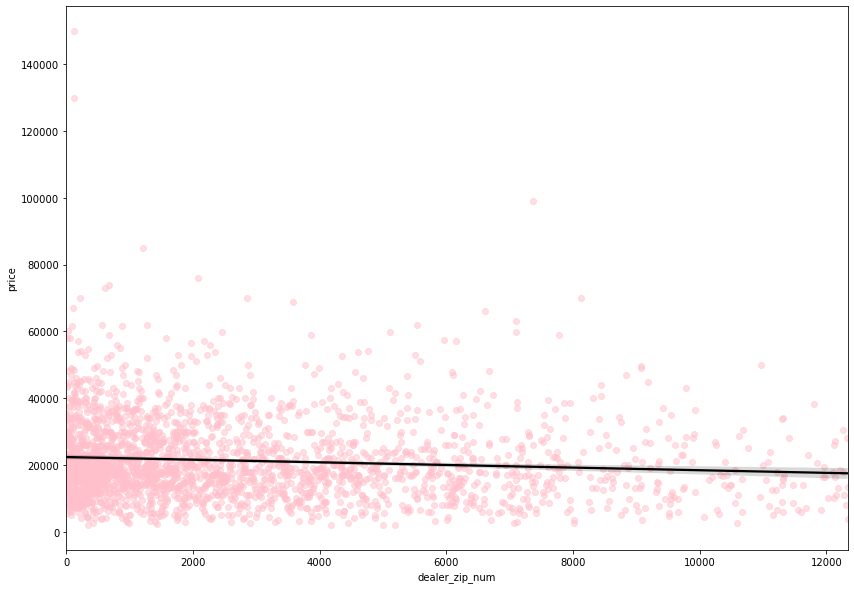

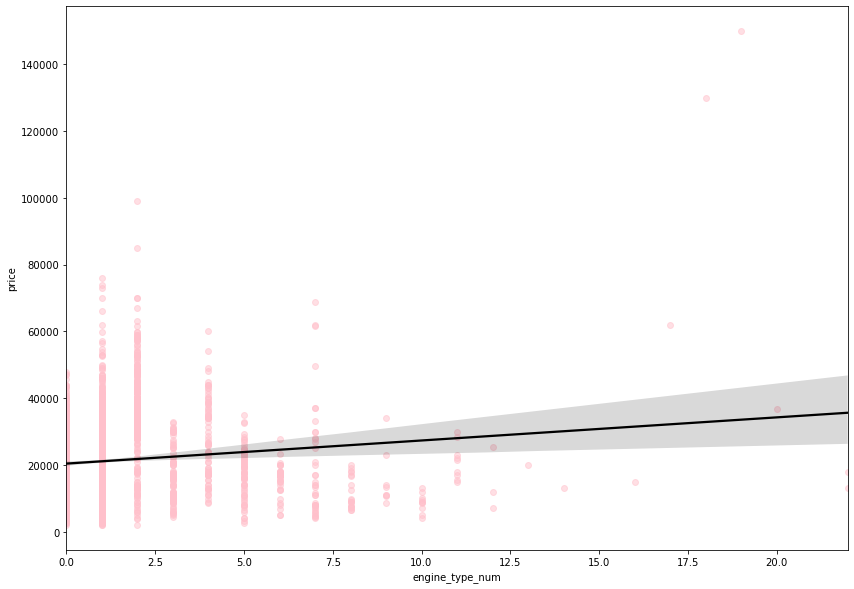

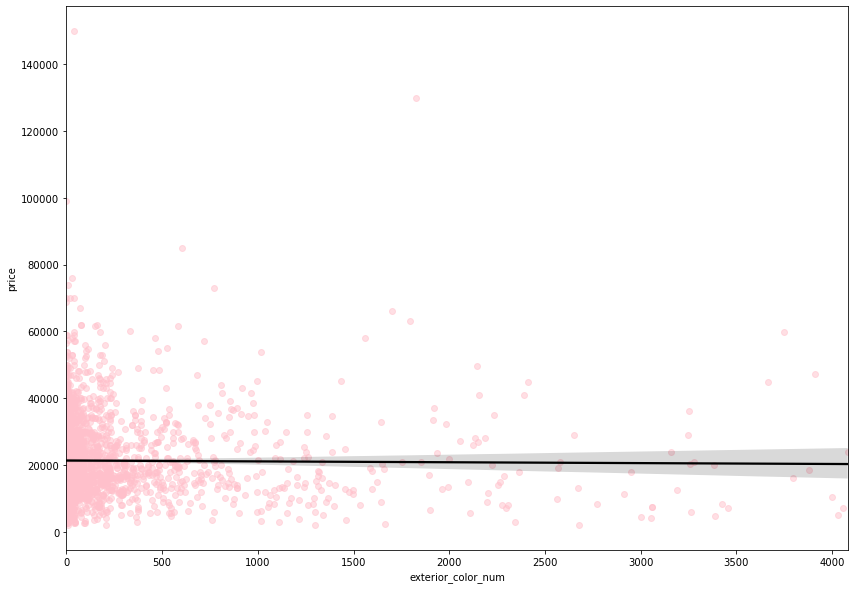

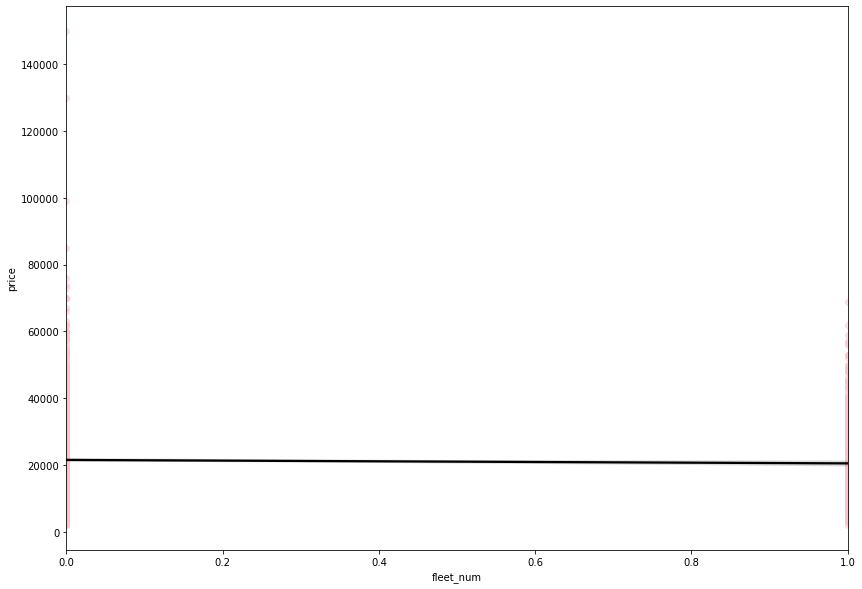

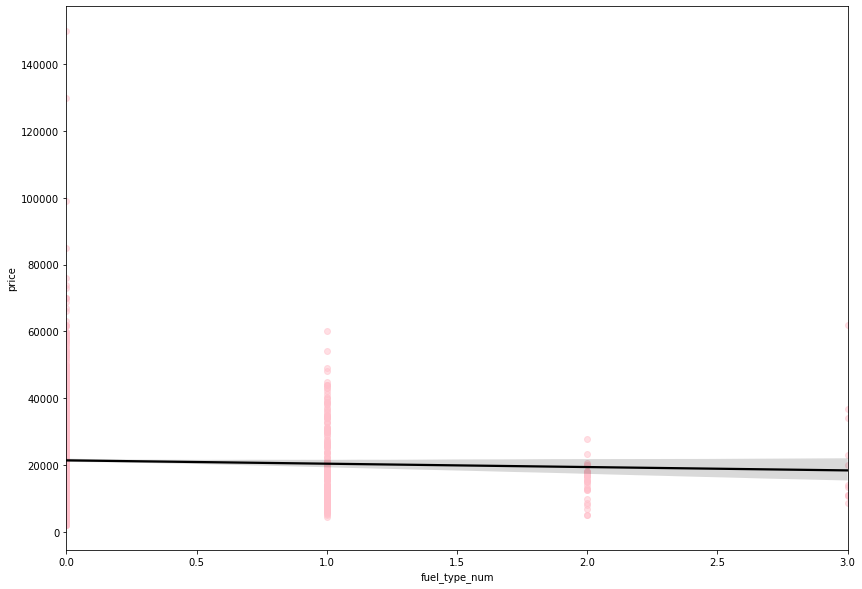

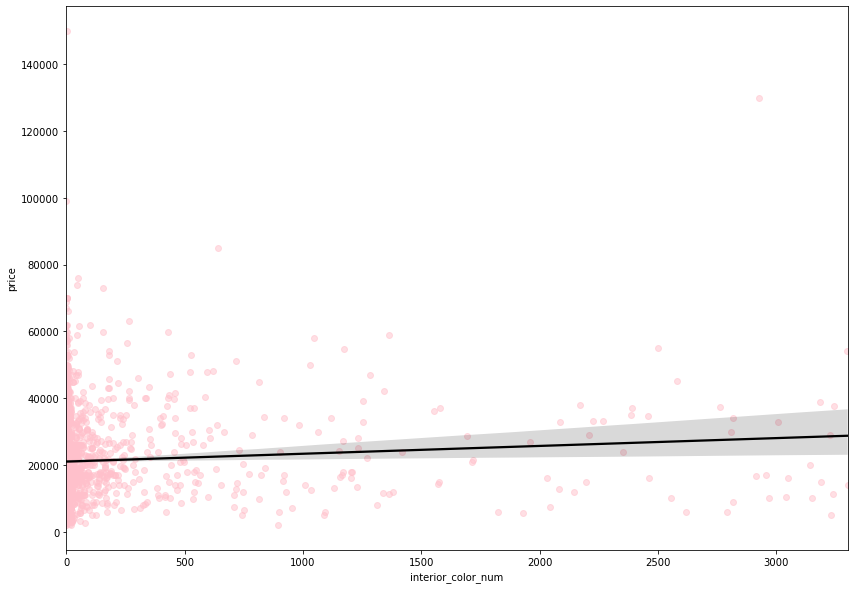

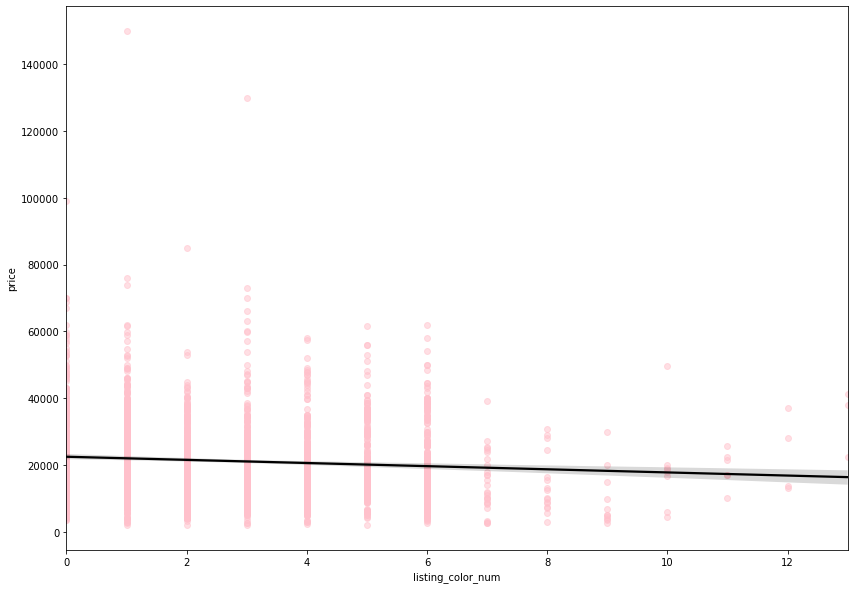

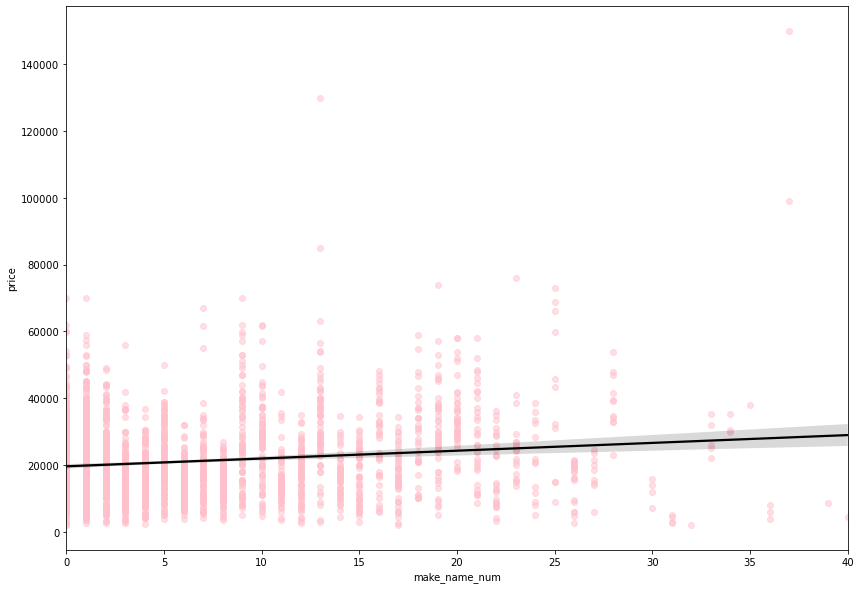

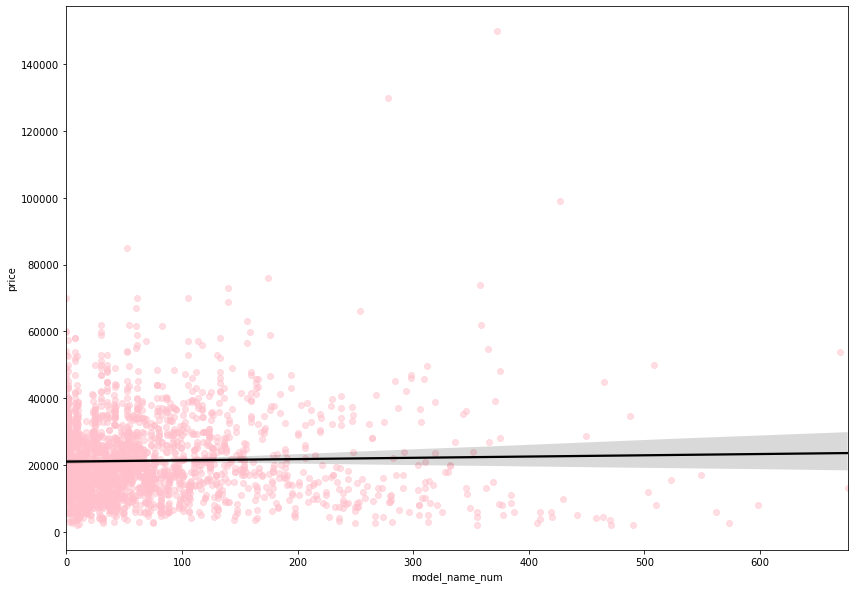

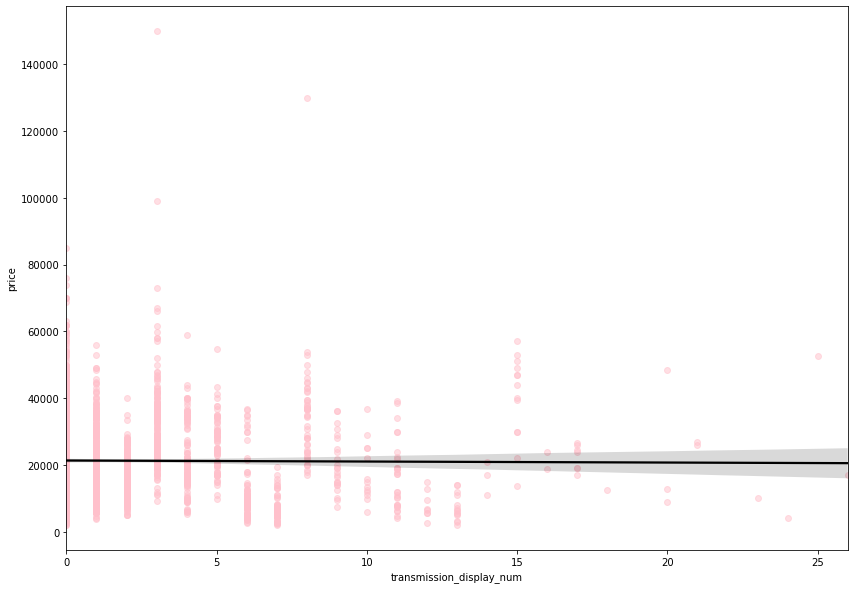

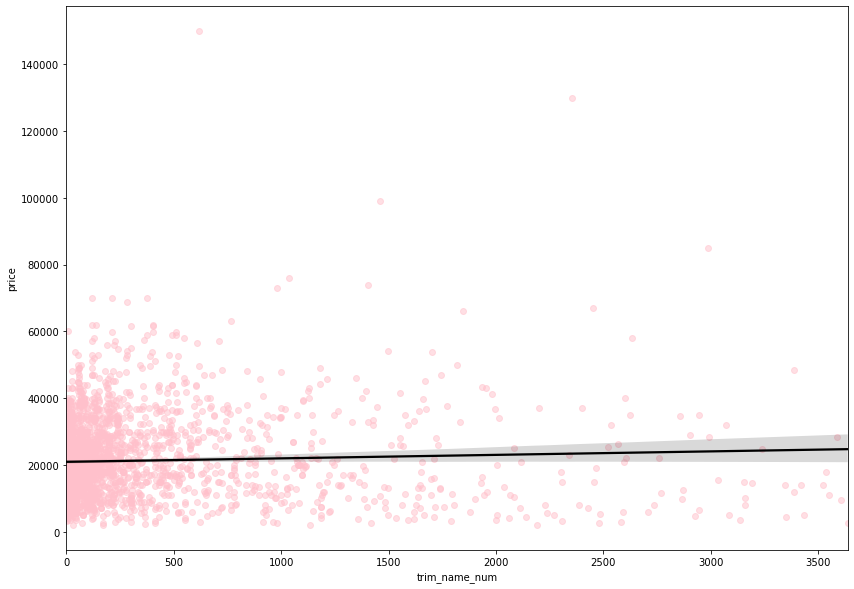

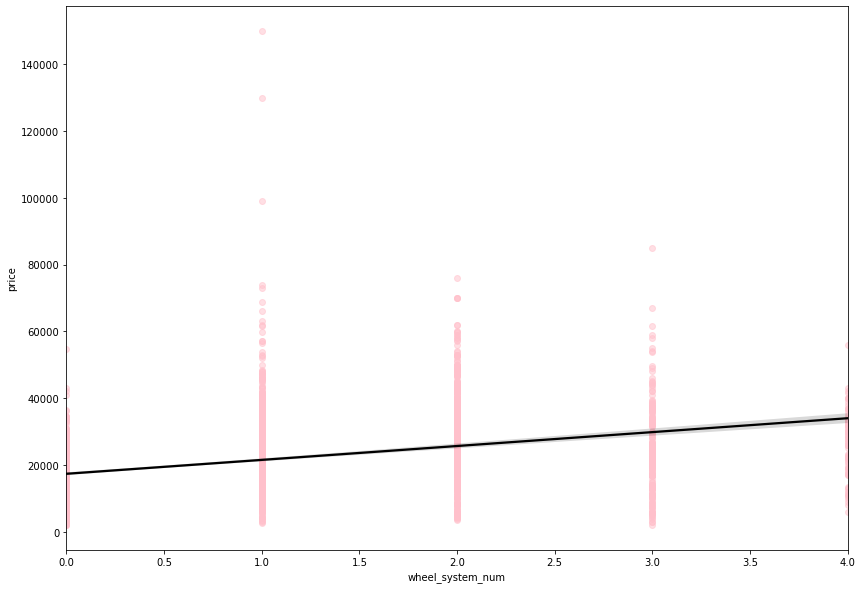

In [8]:
explore.graph_to_target(train_scaled.sample(2500).drop(columns=['vin','city','dealer_zip']),'price')

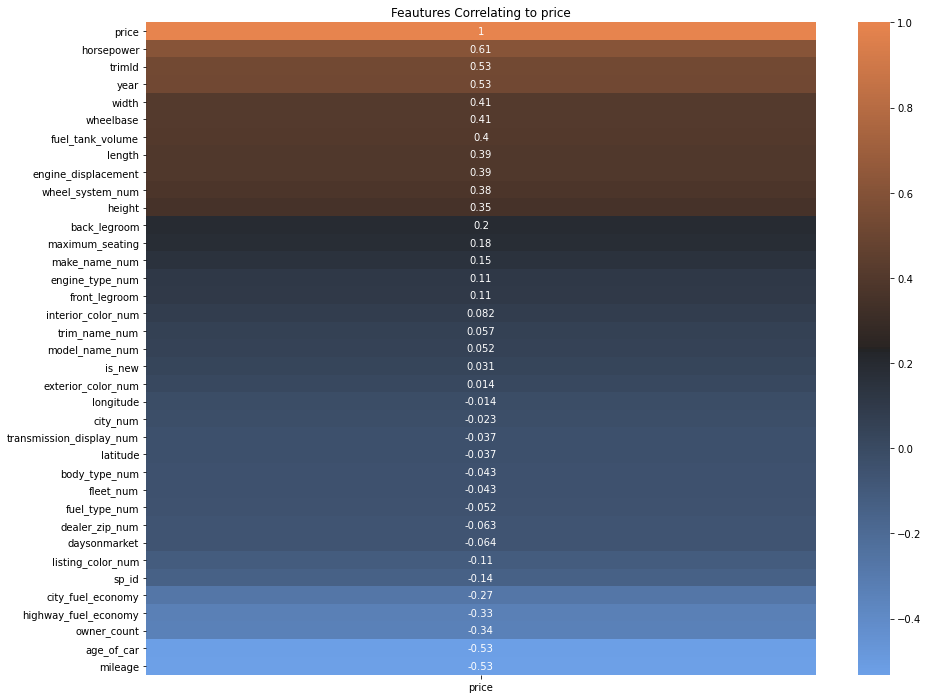

<AxesSubplot:title={'center':'Feautures Correlating to price'}>

In [9]:
explore.get_heatmap(train_scaled, 'price')

### Takeaways
- mostly right tailed, as theres more cars that are least expensive the luxury cars
- Year is left tailed, as this data is scraped from car gurus , majority of the cars listed upon scraping are new listed vehicles for sale
- Based on research, we want to use year, make and model of the car,trim level and milage on the user end in order to get the other factors that are needed for helping predict the car price. The minimum the user should know is the year make and model if the user knows the trim level then that gives us an idea on other useful information that can be used in our model and mileage (such as engine type, or horsepower)

### Statistical testing
Lets make sure Year, Make, and Model hold correlation to price, then we'll look at what rfe to see what else plays a role in predicting car prices. many of our variables are not normally distributed, so we'll use pearsons r correlation 

In [10]:
cont_var = ['year', 'mileage']
cat_var = ['make_name_num', 'model_name_num']
evaluate.get_t_test(cat_var, train_scaled, 'price', 0.05)
evaluate.get_pearsons(cont_var,'price',0.05,train_scaled)

Null Hypothesis: make_name_num has no correlation to price
Alternative hypothesis:  make_name_num has correlation to price 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: model_name_num has no correlation to price
Alternative hypothesis:  model_name_num has correlation to price 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: there is not linear correlation between year and price 
Alternative hypothesis:  year has linear correlation  to price 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------
Null Hypothesis: there is not linear correlation between mileage and price 
Alternative hypothesis:  mileage has linear correlation  to price 
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-------------------------------------


### Feature Elimination
- What feautures does k-best and rfe select as the best drivers

In [11]:
X_train = train_scaled.drop(columns=['vin','price']).select_dtypes(exclude='object')
y_train = train.price

X_validate = validate_scaled.drop(columns=['vin','price']).select_dtypes(exclude='object')
y_validate = validate_scaled.price

X_test = test_scaled.drop(columns=['vin','price']).select_dtypes(exclude='object')
y_test = test_scaled.price

In [12]:
kbest = evaluate.select_kbest(X_train, y_train, 10)

In [13]:
kbest

['engine_displacement',
 'fuel_tank_volume',
 'horsepower',
 'length',
 'mileage',
 'trimId',
 'wheelbase',
 'width',
 'year',
 'age_of_car']

In [14]:
rfe = evaluate.select_rfe(X_train, y_train, 10)

In [15]:
rfe

['city_fuel_economy',
 'engine_displacement',
 'fuel_tank_volume',
 'highway_fuel_economy',
 'horsepower',
 'is_new',
 'mileage',
 'year',
 'age_of_car',
 'fleet_num']

##### We will use the Year, Make , Model, Mileage, Trimid as input from the user, then after having this information , grabbing the avg horsepower and avg city fuel economy , and most occuring wheel system for said car based off information in the dataset.


In [16]:
my_list = ['year', 'make_name_num', 'model_name_num', 'mileage', 'trimId', 'horsepower','engine_displacement']

# Modeling

### Baseline

In [17]:
target = 'price'

In [18]:
baseline = evaluate.baseline_errors(y_train)[2]

In [19]:
baseline

12284.759528496825

### OLS 

In [20]:
ols_train = evaluate.get_model_results(X_train[my_list], y_train, X_train[my_list], y_train, target, normalize=True)  

r2 Score:  0.686199598305413
RMSE Score: 6881.663097961942


In [21]:
ols_validate = evaluate.get_model_results(X_train[my_list], y_train, X_validate[my_list], y_validate, target, normalize=True)   

r2 Score:  0.7213322819615449
RMSE Score: 6517.196875583376


### Lasso Lars 

In [22]:
lasso_train = evaluate.get_model_results(X_train[my_list], y_train, X_train[my_list], y_train, target,model='lasso', alpha= .01 )  

r2 Score:  0.6857135873955842
RMSE Score: 6881.667617150901


In [23]:
lasso_validate = evaluate.get_model_results(X_train[my_list], y_train, X_validate[my_list], y_validate, target,model='lasso', alpha= .01 )  

r2 Score:  0.7208190476073474
RMSE Score: 6517.113119340479


### Tweedie Regressor (GLM)

In [24]:
glm_train  = evaluate.get_model_results(X_train[my_list], y_train, X_train[my_list], y_train, target,model='glm', power = 1)  

r2 Score:  8.769745902946404e-32
RMSE Score: 12284.759528496825


In [25]:
glm_validate = evaluate.get_model_results(X_train[my_list], y_train, X_validate[my_list], y_validate, target,model='glm', power = 1)  

r2 Score:  5.455488107808562e-08
RMSE Score: 12033.180675726468


### Polynomial Regression

In [26]:
poly_train = evaluate.get_model_results(X_train[my_list], y_train, X_train[my_list], y_train, target,model='poly', degree = 3)

r2 Score:  0.8106675065914021
RMSE Score: 5345.388035552139


In [27]:
poly_validate = evaluate.get_model_results(X_train[my_list], y_train, X_validate[my_list], y_validate, target,model='poly', degree = 3)

r2 Score:  0.8610349120548282
RMSE Score: 5046.0903508655


#### Test on 3rd degree polynomial


In [28]:
poly_test = evaluate.get_model_results(X_train[my_list], y_train, X_test[my_list], y_test, target,model='poly', degree = 3)

r2 Score:  0.8686620196697449
RMSE Score: 4974.111999441181


# Exploration of error
- further exploration may suggest that the data should be split into more than 1 model, as the current model is struggling to predict some Super Luxury cars with accuracy, being weighted down by the vast amount of data from the regular car market.

In [29]:
test_scaled['predictions'] = np.round(poly_test[0],2)

In [30]:
test_scaled['Diff'] = abs(test_scaled.price - test_scaled.predictions)

In [31]:
extreme_error_cases = test_scaled[(test_scaled['Diff'] >= 10000)]

In [32]:
extreme_error_cases= extreme_error_cases[['vin', 'horsepower', 'mileage','price', 'predictions', 'Diff']]

In [33]:
extreme_error_cases.sort_values(by="Diff")

,vin,horsepower,mileage,price,predictions,Diff
197299,2C4RDGCGXKR693956,0.364407,-0.076700,17498.0,27504.55,10006.55
38446,4S4BSANC0K3359499,-0.550847,-0.378633,30278.0,20263.84,10014.16
111160,2C3CDZAG6KH688011,0.550847,-0.559733,25500.0,35522.25,10022.25
150436,1J4BA3H18BL562776,-0.322034,0.718623,24999.0,14976.64,10022.36
1711,1FATP8UH1K5170581,0.593220,-0.099140,23598.0,33625.00,10027.00
...,...,...,...,...,...,...
140872,WDDXJ8JB5LA041092,3.076271,-0.657363,173900.0,116053.50,57846.50
149424,1C4JJXFM5LW195034,0.169492,-0.726121,89900.0,31948.23,57951.77
155405,WDDUX7GB5HA339040,2.398305,-0.689201,129989.0,65136.85,64852.15
113213,WDDUG7KB4JA342329,3.228814,-0.526384,149888.0,81763.56,68124.44


# Conclusion
- As you can see above the super cars are being valued either extremely low or extremely high suggesting that these cars should be seperated into their own market. 
- It also has trouble valuing classic (collectible) cars. cars that are older, but still hold value. because cars dont always depreciate over time.
- Model may need more cars older cars as the dataset only looks at cars up to 1995
- model might rely too much on horsepower as an idicator of price.
- We will revisit and split the data into premium and regular markets based on the model of the car in order to improve accuracy. 
- we will also revisit classic  car handling.

### Model Deployment 
- This model will be used and deployed to a streamlit application 

In [49]:
import pickle
data = {'model': poly_train[2], 'poly': poly_train[3], 'ytrain': y_train ,'year': train_scaled['year'], 'car_make': train_scaled['make_name_num'],'car_model':train_scaled['model_name_num'], \
        'mileage': train_scaled['mileage'], 'trimId': train_scaled['trimId'], 'horsepower':train_scaled['horsepower'],\
        'engine_displacement': train_scaled['engine_displacement'], 'df': cars_df}
with open('car_model.pkl', 'wb') as file:
    pickle.dump(data, file)